# Can We Predict the Next NFL Pro Bowler?


## Overview and Motivation

Every year, the National Football League holds a draft for players first entering the league, most of whom enter directly from playing college football. Teams are given a draft position depending on how well they fared the previous year, with the worst teams getting higher picks, and they select the rights to sign these players to contracts. Before that happens, every team does intensive scouting on potential draft picks to determine how highly they value certain players.

One aspect of this evaluation is the NFL Scouting Combine. This occurs every year in February; players are invited to go through a variety of physical drills that are intended to measure their raw athletic ability, including speed, strength, and agility. Our goal is to evaluate whether the Scouting Combine is predictive of future success in the NFL, which drills are most predictive of success, and whether NFL teams are emphasizing the right drills when using the Scouting Combine to evaluate players.

How do we define whether a player was "successful"? There are many different ways we could do this, but for this project we have chosen to define success as whether or not a player made the NFL Pro Bowl at any point in his career. The Pro Bowl is the NFL's All-Star game; players are voted in by other players and fans based on their performance during the season.


## Related Work

Most who write about or research the NFL Scouting Combine's predictive ability tend to think its usefulness isn't in line with the amount of attention it receives. <a href='http://ftw.usatoday.com/2015/02/pro-bowl-players-bad-combine-nfl'>Many</a> <a href='http://www.nfl.com/combine/story/0ap2000000326175/article/nfl-scouting-combine-freaks-and-flops-from-the-past-five-years'>articles</a> have been <a href='http://ftw.usatoday.com/2015/02/pro-bowl-players-bad-combine-nfl'>written</a> about players who flopped at the Combine and then did well in the NFL, and about so-called "workout warriors" who excelled at the Combine and went on to be terrible players. Some articles go as far as to call the NFL Draft Combine <a href='http://ftw.usatoday.com/2015/02/nfl-draft-combine-is-dumb'>"dumb"</a>.

<a href='https://www.bostonglobe.com/2015/04/30/combine/M23aKw0OdxpwgLlTsXlHbL/story.html'>The Boston Globe</a> did a really good visualization to try to examine the relationship between impressive Combine results and success in the Pro Bowl, plotting the combine results of some elite NFL players and how their results compared to the average player. Unsurprisingly, it particularly drew attention to Tom Brady, noting that he "failed to impress at the NFL Combine in 2000 and fell to the sixth round in the draft, but became a 10-time Pro Bowler for the Patriots". This may be a bit misleading, since, as we will explain, athletic ability is much less important for quarterbacks than for other positions in the league.

Overall perception of the Combine is clearly that it isn't worth paying close attention to. We will keep that in mind as we progress and not try to force a significant result when, in reality, we may not find one.

## Initial Questions

We hinted at these in our overview/motivation, but let's lay them out more explicitly and in more detail.

1. Is the NFL Scouting Combine predictive of success in the NFL? As we saw with the related work, many people believe that it isn't very predictive. We'd like to fit a model that predicts success based on performance at the Combine and see if we can tease out any large effects.

2. Which aspects are most predictive, and for which players? Perhaps there's one drill that does a decent job of telling us which player is more likely to be good. That effect can also vary across positions, so we will want to control for that in some way.

3. How do NFL teams use Combine results, and how does this compare to which aspects are most predictive? We also want to see which aspects of the Combine are most likely to lead NFL teams to predict that the player will be successful. We can compare this to which aspects are actually predictive of success, and, if there are differences, perhaps recommend NFL teams shift their focus in their evaluation of new players.

### NOTE TO HENRIQUE AND CRYSTAL: RUN THE FIRST TWO CELLS THEN YOU CAN SKIP DOWN TO THE GROUPED DATA SECTION

But if that doesn't work for some reason then just run everything; it shouldn't take more than 15-20 seconds.

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm


import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [2]:
alldata = pd.read_csv("alldata.csv")
ungrouped = pd.read_csv("ungrouped.csv")

##Data

### Combine Data

Our main data file contains results from the NFL Scouting Combine from 1999 through 2015. Our data file can be found at this link: http://nflsavant.com/about.php

Here is a description of the drills we plan to consider, along with their variable names in the data set.

- `fortyyd`: time in the forty-yard dash, which is an all-out sprint for 40 yards
- `bench`: number of times a player can bench press 225 pounds
- `vertical`: vertical jump, where a player stands flat-footed then jumps up as high as he can. Measured in inches.
- `broad`: broad jump, where a player stands flat-footed and then jumps forward as far as he can.
- `threecone`: time in the three cone drill; players run around three cones set in an L shape in a way that is intended to measure their ability to change direction
- `twentyss`: time in the shuttle run; the player runs 5 yards, changes direction to run 10 yards, and changes direction again to run 5 yards

We are also given data on the player's position, which will become important later for sorting, as well as height, weight, college attended, and pick with which they were eventually drafted, if they were selected (the draft is only 7 rounds, so some players go without being selected).

In [3]:
nflcomb = pd.read_csv("combine.csv")
nflcomb.head()

,year,name,firstname,lastname,position,heightfeet,heightinches,heightinchestotal,weight,arms,...,vertical,broad,bench,round,college,pick,pickround,picktotal,wonderlic,nflgrade
0,2015,Ameer Abdullah,Ameer,Abdullah,RB,5,9,69,205,0,...,42.5,130,24,0,Nebraska,NaN,0,0,0,5.9
1,2015,Nelson Agholor,Nelson,Agholor,WR,6,0,72,198,0,...,0.0,0,12,0,USC,NaN,0,0,0,5.6
2,2015,Jay Ajayi,Jay,Ajayi,RB,6,0,72,221,0,...,39.0,121,19,0,Boise St.,NaN,0,0,0,6.0
3,2015,Kwon Alexander,Kwon,Alexander,OLB,6,1,73,227,0,...,36.0,121,24,0,LSU,NaN,0,0,0,5.4
4,2015,Mario Alford,Mario,Alford,WR,5,8,68,180,0,...,34.0,121,13,0,West Virginia,NaN,0,0,0,5.3


Since we do not yet know who will make the 2016 Pro Bowl, we will exclude players who participated in the 2015 Scouting Combine.

In [4]:
nflcomb = nflcomb[nflcomb['year'] < 2015]
nflcomb.head()

,year,name,firstname,lastname,position,heightfeet,heightinches,heightinchestotal,weight,arms,...,vertical,broad,bench,round,college,pick,pickround,picktotal,wonderlic,nflgrade
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,6,1,73,195,0,...,30.5,117,4,6,Wisconsin,0,16,176,0,5.2
323,2014,Davante Adams,Davante,Adams,WR,6,1,73,212,0,...,39.5,123,14,2,Fresno St.,0,21,53,0,6.0
324,2014,Mo Alexander,Mo,Alexander,SS,6,1,73,220,0,...,38.0,123,0,4,Utah St.,0,14,110,0,4.9
325,2014,Ricardo Allen,Ricardo,Allen,CB,5,9,69,187,0,...,35.5,117,13,5,Purdue,0,19,147,0,5.1
326,2014,Jace Amaro,Jace,Amaro,TE,6,5,77,265,0,...,33.0,118,28,2,Texas Tech,0,17,49,0,5.4


In [5]:
nflcomb.columns

Index([u'year', u'name', u'firstname', u'lastname', u'position', u'heightfeet',
       u'heightinches', u'heightinchestotal', u'weight', u'arms', u'hands',
       u'fortyyd', u'twentyyd', u'tenyd', u'twentyss', u'threecone',
       u'vertical', u'broad', u'bench', u'round', u'college', u'pick',
       u'pickround', u'picktotal', u'wonderlic', u'nflgrade'],
      dtype='object')

Most of these variables are unnecessary or contain a ton of missing values, so we can drop them from our data set.

In [6]:
dropvars = ['heightfeet', 'heightinches', 'arms', 'hands', 'wonderlic', 'nflgrade', 'pick', 'twentyyd', 'tenyd']
nflcomb.drop(dropvars, axis = 1, inplace=True)
nflcomb.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,0,4,Utah St.,14,110
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,0.00,35.5,117,13,5,Purdue,19,147
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49


Missing values in this data set are coded as 0, so we need to replace those with NaNs in most cases. For now let's replace all 0 values with NaN.

In [7]:
nflcomb.replace(0, np.nan, inplace=True)
nflcomb.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49


For the workout results the missing value makes sense; we don't want to assume results we don't have. However, for the draft round and pick results, a missing value actually means that the player was not drafted, not that we don't know the player's draft position. So we want our data to reflect that. For round, let's code undrafted players as being drafted in round 8, which doesn't exist. We can leave their pick within the round and pick total as missing for now.

In [8]:
nflcomb.loc[np.isnan(nflcomb.round), 'round'] = 8
nflcomb[nflcomb.round > 6].head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
327,2014,Antonio Andrews,Antonio,Andrews,RB,70,225,4.82,4.49,7.24,29.5,106,20,8,Western Kentucky,NaN,NaN
329,2014,Matt Armstrong,Matt,Armstrong,C,74,302,5.36,NaN,NaN,NaN,NaN,NaN,8,Grand Valley St.,NaN,NaN
330,2014,George Atkinson,George,Atkinson,RB,73,218,4.48,4.46,7.07,38.0,121,19,8,Notre Dame,NaN,NaN
332,2014,Dion Bailey,Dion,Bailey,SS,72,201,4.66,4.15,6.97,34.0,113,NaN,8,USC,NaN,NaN
336,2014,Deion Belue,Deion,Belue,CB,71,182,NaN,NaN,NaN,NaN,NaN,11,8,Alabama,NaN,NaN


#### Position Analysis

Now that we've cleaned the data a little bit, we would like to sort it by position. The reason for this is that different players can have vastly different roles on the field, which means that a physical trait which is vitally important for one player is essentially meaningless for others. For some of our models, such sorting will be necessary.

Here is a description of each of the positions, sorted by offense and defense. For a diagram of standard offensive/defensive alignments, see here: https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Positions_American_Football.svg/2000px-Positions_American_Football.svg.png

**Offense**

- *Quarterback*: His primary job is to throw the ball to wide receivers and tight ends (see below). Arm strength and agility are the most important physical attributes for a quarterback, but success at this position depends more on mental attributes than phyiscal. Because of this uniqueness, as well as the small sample size at the positiion, we anticipate Quarterbacks to be very difficult to forecast based solely on Combine results, and we will leave them out of our grouped analysis. 

- *Running Back*: In addition to forward passes, teams can also advance the ball forward simply by carrying the ball. The running back does most of this, in addition to sometimes catching passes. Some running backs rely on speed and agility to stay away from potential tacklers, others rely on strength to power through them, and some are good at both.

- *Full Back*: Full back. Lines up in front of the running back and mainly acts as an extra blocker on run plays, in addition to occasionally running the ball himself or catching passes.

- *Wide Receiver*: Runs down the field to try to catch forward passes. Generally smaller and faster than most players, though the best receivers are also tall, in order to outjump defenders.

- *Tight End*: Essentially a hybrid between an offensive tackle and a wide receiver. They usually line up next to the offensive line and play an important role in blocking on run plays, but they can also catch passes on passing plays. Faster than OTs but slower than WRs in general, and stronger than WRs but weaker than OTs in general.

- *Offensive Tackle*: Offenses have five offensive linemen, whose job is to prevent defenders from tackling the player carrying the ball. Most of these players are around 300 pounds. Offensive tackles play the outermost position on the line. Strength is vital, because most of the players they're blocking are just as big. Agility also plays a part, especially on passing plays, because most of the players trying to tackle the quarterback, called pass rushers, are very fast in addition to strong, and tackles tend to have to take on the defense's fastest pass rushers.

- *Offensive Guard*: Offensive Guard. These offensive linemen play just inside the offensive tackles. Strength is likely to be a little more important, and agility less so, compared to offensive tackles; guards are relied on more for run blocking and blocking pass rushers who rely on strength rather than speed.

- *Center*: The middle player on the offensive line. Essentially the same as a guard, except the center also starts the play by snapping the ball to the quarterback. They are most often responsible for calling out blocking schemes depending on how the defense lines up.

**Defense**

- *Defensive End and Defensive Tackle*: They line up on the outside of the defensive line and play a big role in both defending run plays and rushing the quarterback on passing plays. Usually very large and strong, but also fast and agile. 

- *Outside Linebacker and Inside Linebacker*: Linebackers play immediately behind the defensive linemen. On running plays, they are the players expected to take down the ball-carrier. On passing plays, they sometimes will rush the quarterback and sometimes will drop back to defend passes thrown. Outside linebackers usually play a bigger role in rushing the passer than inside linebackers; inside linebackers play between the outside linebackers and usually paly a bigger role in defending the run. Their athleticism is similar to tight ends and running backs, and often they are tasked with covering these players when they go out to catch passes.

- *Cornerback*: These players play along the line of scrimmage on the outside and are responsible for covering wide receivers as they go out to catch passes. They are similar to wide receiver in athleticism, except they are usually smaller and faster than the players they're covering.

- *Free Safety and Strong Safety*: Safeties play behind the linebackers. They're the last line of defense in case a running back gets past the linebackers or a receiver gets past the cornerbacks. Strong safeties usually play a bigger role in the running game than free safeties. They're usually a bit slower and bigger than cornerbacks, and often cornerbacks will convert to safety later in their career if their speed starts to fade.

**Special Teams**

- *Kicker*: Kicks field goals, which are worth half as much as touchdowns, and performs kickoffs, which is when the team gives the ball back to the other team following a score.

- *Punter*: Teams have four downs to get a first down. If after third down they haven't gained enough yards for a first, often they will kick the ball to the other team via punt rather than risk giving the ball back if they fail to convert.

Let's look at the different position values we have in our data set.

In [9]:
nflcomb['position'].unique()

array(['WR', 'SS', 'CB', 'TE', 'RB', 'C', 'OLB', 'OT', 'OG', 'ILB', 'QB',
       'K', 'DT', 'FS', 'NT', 'P', 'DE', 'FB', 'LS', 'OC'], dtype=object)

Most of these abbreviations are straightforward: RB for Running back, etc. LS stands for long snapper, which is similar to the center but specializes in snapping the ball on punts and field goals, which requires snapping the ball a longer distance. OC and C both refer to Center. NT stands for nose tackle, which is a special type of defensive tackle who specializes almost exclusively in stopping the run.

The question now becomes how we can break up our analysis by position without combining positions which are too unlike each other, and while also maintaining a large enough sample size that we may still find a signal.

We also need to take into account right censorship: some players who are early in their careers haven't made the Pro Bowl yet but will make the Pro Bowl in 2016 or later. Based on that we need to exclude more recent years. We expect we will need to exclude at least five years worth of data, possibly more. However, we also have to compete with the small sample size in our data; the more we exclude, the less likely we are to find a signal.

Let's create a new data frame including only players in the 2009 or earlier Combine, and let's see the sample size at each position.

In [10]:
drop09 = nflcomb[nflcomb.year <= 2009]
combpos = drop09.groupby('position')
combpos.count()

,year,name,firstname,lastname,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
position,,,,,,,,,,,,,,,,
CB,293,293,293,293,293,293,293,218,2,272,269,236,293,213,213,213
DE,262,262,262,262,262,262,262,209,8,229,228,230,262,184,184,184
DT,232,232,232,232,232,232,231,173,0,195,187,199,232,160,160,160
FB,87,87,87,87,87,87,87,70,0,81,80,78,87,54,54,54
FS,147,147,147,147,147,147,147,111,0,134,129,129,147,97,97,97
ILB,146,146,146,146,146,146,146,112,0,126,124,125,146,92,92,92
OC,100,100,100,100,100,100,99,87,0,88,88,92,100,56,56,56
OG,220,220,220,220,220,220,220,174,0,188,181,191,220,123,123,123
OLB,216,216,216,216,216,216,216,175,0,188,187,187,216,154,154,154


From these numbers a few groupings make obvious sense, because they produce a large sample size and combine positions requiring similar skills:
    
1. Lump CB, FS and SS together into the "defensive back" category
2. Lump OT, OG and OC together into the "offensive line" category
3. Lump OLB and ILB together into the "linebacker" category
4. Lump DT and DE together into the "defensive line" category

The rest of the positions could be lumped together in any number of ways. We will exclude K, P, and QB due to small sample size and lack of obvious grouping options.

To aid in these decisions we first glanced at the averages at the positions in both physical attributes and performance in certain drills.

In [11]:
combpos.mean()

,year,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,pickround,picktotal
position,,,,,,,,,,,,
CB,2004.122867,71.259386,192.034130,4.490751,4.156927,6.710000,36.303309,121.133829,14.495763,4.757679,17.042254,101.154930
DE,2003.877863,75.835878,268.125954,4.845076,4.411866,7.306250,33.054585,113.583333,23.665217,5.049618,18.456522,112.250000
DT,2003.793103,75.172414,304.189655,5.103377,4.614682,NaN,29.497436,105.117647,26.984925,5.168103,17.300000,113.918750
FB,2003.517241,72.839080,244.505747,4.751954,4.373000,NaN,32.759259,112.825000,22.705128,6.172414,21.148148,157.314815
FS,2004.040816,72.918367,204.231293,4.566531,4.201802,NaN,36.089552,120.279070,16.310078,5.503401,19.051546,126.340206
ILB,2003.712329,73.664384,242.082192,4.763904,4.307143,NaN,33.134921,113.467742,22.416000,5.349315,18.956522,111.532609
OC,2003.920000,75.410000,301.720000,5.235859,4.623333,NaN,28.801136,101.602273,25.923913,5.810000,20.339286,123.589286
OG,2003.259091,76.131818,314.045455,5.325182,4.771437,NaN,27.875000,99.801105,25.214660,6.045455,18.934959,136.300813
OLB,2004.134259,74.055556,238.060185,4.681528,4.261829,NaN,34.558511,116.609626,22.074866,5.041667,18.051948,112.922078


Here are the choices we made:

- Add tight ends and fullbacks to the linebacker category. These positions are very different in role, but the athletic skills needed of athletes at both positions are very similar, and their averages in terms of weight, forty yard dash time, and bench press time are similar. This isn't idea from an analysis perspective, because we'd like to keep them separate, but the small sample size in TE/FB means that we can't analyze them on their own, and their athletic makeup makes them poor fits to be combined with other offensive positions.
- Combine running backs and wide receivers into one category. We came in expecting these positions to be too different to justify combining, but they're actually pretty similar in terms of physical attributes and performance in the drills, and the sample size in the running back group isn't large enough to make it okay to leave them on their own.

At this point we are left with 5 different groups. Since we plan to fit separate models to each of these groups, we would like to reduce this further. To do so, we make the following choices.

- Combine offensive linemen and defensive linemen into a general linemen category
- Combine defensive backs with running backs and wide receivers to create a "backs and receivers" category

In general, we are compromising the ability to do our analysis on a position-specific level by doing this. In most cases, such ability was already compromised by a small sample size. In cases where it wasn't, we chose to limit the number of groups so that we didn't have to fit too many different models. Using interaction terms for all positions would be even more unwieldy considering the number of different positions and the number of variables we're including. We will attempt to be more focused in our position analysis using our ungrouped data, but for the grouped case, our focus is to reduce the number of models we need to fit and make sure our sample size is large enough to find a signal.

We will do these combinations once we take care of adding the Pro Bowl data. For now we will create lists of positions in each group for later reference. Backs refers to the backs/receivers group, Line refers to the linemen, and Hybrid refers to the linebackers/tight ends group. 

In [4]:
backs = ['CB', 'FS', 'SS', 'RB', 'WR']

# Peeking at later data reveals that OC is sometimes coded as LS or C
line = ['DT', 'DE', 'NT', 'OT', 'OG', 'OC', 'C', 'LS']

# Stands for hybrid; ILB is sometimes coded as MLB in future data
hyb = ['OLB', 'ILB', 'MLB', 'TE', 'FB']

## Pro Bowl Data

The Combine data set didn't include any Pro Bowl data, so we need to scrape that for ourselves. Pro Football Reference has the roster from every year available in a nice CSV format, so we simply needed to download all the files and then import them as their own data frames.

Note that these data indicate the year in which these players were named to the Pro Bowl, but the game to which the players were named was played in the next year. For example, a player named to the Pro Bowl in 1999 in the data would play in the 2000 Pro Bowl. We will correct this later.

In [13]:
years = range(1999, 2015, 1)
filenames = {year:"years_" + str(year) + "_probowl_pro_bowl.csv" for year in years}
filenames

{1999: 'years_1999_probowl_pro_bowl.csv',
 2000: 'years_2000_probowl_pro_bowl.csv',
 2001: 'years_2001_probowl_pro_bowl.csv',
 2002: 'years_2002_probowl_pro_bowl.csv',
 2003: 'years_2003_probowl_pro_bowl.csv',
 2004: 'years_2004_probowl_pro_bowl.csv',
 2005: 'years_2005_probowl_pro_bowl.csv',
 2006: 'years_2006_probowl_pro_bowl.csv',
 2007: 'years_2007_probowl_pro_bowl.csv',
 2008: 'years_2008_probowl_pro_bowl.csv',
 2009: 'years_2009_probowl_pro_bowl.csv',
 2010: 'years_2010_probowl_pro_bowl.csv',
 2011: 'years_2011_probowl_pro_bowl.csv',
 2012: 'years_2012_probowl_pro_bowl.csv',
 2013: 'years_2013_probowl_pro_bowl.csv',
 2014: 'years_2014_probowl_pro_bowl.csv'}

Now we want to save each of these csvs as a DataFrame in a dictionary keyed by its year.

In [14]:
filedict = {}
for year in years:
    
    roster = pd.read_csv(filenames[year])
    
    # Drops some erroneously generated rows with no players and lots of NaNs
    roster = roster[np.isfinite(roster['Age'])]
    
    # Drops all unneeded rows
    filedict[year] = roster[['Pos', 'Unnamed: 1', 'Conf', 'Tm']]
    
filedict[1999].head()

,Pos,Unnamed: 1,Conf,Tm
0,WR,Marvin Harrison+%,AFC,IND
4,RB,Edgerrin James+%,AFC,IND
8,LG,Larry Allen+%,NFC,DAL
12,LT,Tony Boselli+%,AFC,JAX
16,RLB,Kevin Hardy+%,AFC,JAX


### Cleaning the Pro Bowl Files

In [15]:
filedict[1999]["Unnamed: 1"].values

array(['Marvin Harrison+%', 'Edgerrin James+%', 'Larry Allen+%',
       'Tony Boselli+%', 'Kevin Hardy+%', 'Tony Gonzalez+%',
       'Sam Madison+%', 'Olindo Mare+%', 'Jevon Kearse+%',
       'Kevin Carter+%', 'Marshall Faulk+%', 'Orlando Pace+%',
       'Kurt Warner+%', 'Ray Lewis+%', 'Derrick Brooks+%', 'John Lynch+%',
       'Warren Sapp+%', 'Mitch Berger+%', 'Darrell Russell+%',
       'Glyn Milburn+%', 'Cris Carter+%', 'Lawyer Milloy+%',
       'Kevin Mawae+%', 'Bruce Matthews+%', 'Charles Woodson+%',
       'Deion Sanders+%', 'Carnell Lake+%', 'Isaac Bruce+%',
       'Michael Bates+%', 'Trevor Pryce+%', 'Jeff Christy+%', 'Tom Tupa+%',
       'Tom Nalen+%', 'Will Shields+%', 'Zach Thomas+%', 'Mike Alstott+%',
       'Ruben Brown+%', 'Wesley Walls+%', 'Peyton Manning+%',
       'Tony Brackens+%', 'Jimmy Smith+%', 'Jessie Armstead+%',
       'Eddie George+%', 'Todd Lyght+%', 'Peter Boulware+%',
       'Jonathan Ogden+%', 'Hardy Nickerson+%', 'Stephen Davis+%',
       "Tre' Johnson+%

We will focus on modifying the player names and building a dictionary of Pro Bowl Rosters. However, we may need to refer back to the original data frames if we find players with the same name in our Combine file; more on that later.

The % symbol after players' names is supposed to indicate that they didn't play in the game, but it seems that every player has a % symbol, so this is likely inaccurate; we will drop it.

The + symbol is potentially of interest; it indicates that a player played in the game as an injury replacement. This means that the player wasn't selected to the Pro Bowl in initial voting, but they were just outside of being selected and played because one of the selected players got hurt. Ideally we would prefer to exclude these players; such inclusion is based on a selected player getting injured, which is pretty random year to year.

Examining the data, it seems that the + symbol is only used to indicate the player actually didn't play starting in 2009. So starting with 2009, we will exclude players with a + symbol; for years before that we will include all players.

In [16]:
rosterdict = {}
for year in years:
    
    roster = [x for x in filedict[year]["Unnamed: 1"].values if str(x) != 'nan']
    
    if year < 2009:
        # Removes the %+ substring for every player
        rosterfinal = [x[:-2] for x in roster]
    else:
        rosterfinal = [x[:-1] for x in roster if "+" not in x]
        
    rosterdict[year] = rosterfinal

In [17]:
print rosterdict[1999][:5], rosterdict[2011][:5]

['Marvin Harrison', 'Edgerrin James', 'Larry Allen', 'Tony Boselli', 'Kevin Hardy'] ['Aaron Rodgers', 'Drew Brees', 'Tom Brady', 'Eli Manning', 'Ben Roethlisberger']


It looks like the player names are in the format we want, with no symbols and the complete name included. Let's see the number of Pro Bowlers from each year.

In [18]:
for year in years:
    print year, len(rosterdict[year])

1999 91
2000 97
2001 106
2002 99
2003 100
2004 101
2005 98
2006 102
2007 103
2008 98
2009 85
2010 86
2011 84
2012 86
2013 88
2014 89


This is problematic; it looks like the data files before 2009 included players who played as injury replacements but didn't correctly designate them as such; notice the larger roster sizes in those years. 

Since the number of injury replacements each year seems consistent enough, and the players named as replacements are still very good, since they just missed out on being voted in, we will include injury replacement players in all years. This means we need to redo our code from before to rebuild the dictionaries.

In [19]:
rosterdict = {}
for year in years:
    
    roster = [x for x in filedict[year]["Unnamed: 1"].values if str(x) != 'nan']
    
    if year < 2009:
        # Removes the %+ substring for every player
        rosterfinal = [x[:-2] for x in roster]
    else:
        rosterfinal = [x.replace("+", "").replace("%", "") for x in roster]
        
    rosterdict[year] = rosterfinal

In [20]:
for year in years:
    print year, len(rosterdict[year])

1999 91
2000 97
2001 106
2002 99
2003 100
2004 101
2005 98
2006 102
2007 103
2008 98
2009 121
2010 116
2011 109
2012 118
2013 116
2014 115


This looks problematic for a different reason: there seem to be a lot more injury replacements in 2009 and beyond. This can be explained by a logistical change made to the Pro Bowl starting in 2009: the Pro Bowl, which used to be played the week after the Super Bowl, was moved to the week before. This means that any player on a Super Bowl team would be replaced even if they weren't injured, and it likely means that more players who are injured during the playoffs will decide not to play.

This could cause bias in our analysis; many players who are declared Pro Bowlers in 2009 or beyond likely would not have been declared Pro Bowlers in 2008 or earlier due to this change. We don't have a clear way to address this other than to acknowledge it as a potential weakness and hope it doesn't severely skew our analysis later on.

### Combining the Pro Bowl and Combine data sets

Now we want to pull these two sources together into one. First, let's check our Combine data for players who have the same name.

In [21]:
dups = nflcomb[nflcomb.name.duplicated()]
dups.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
1222,2012,Phillip Thomas,Phillip,Thomas,FS,71,198,4.74,NaN,NaN,33.0,122,14,8,NaN,NaN,NaN
1385,2011,Andrew Jackson,Andrew,Jackson,OG,77,299,5.27,4.65,NaN,28.0,98,25,7,Fresno State,7,210
1548,2011,Nate Williams,Nate,Williams,SS,73,211,4.68,4.15,NaN,30.5,114,17,8,NaN,NaN,NaN
1588,2010,Charles Brown,Charles,Brown,OT,78,303,5.24,NaN,NaN,31.5,NaN,21,2,USC,32,64
1915,2009,Will Davis,Will,Davis,DE,74,261,4.84,4.45,NaN,33.0,115,27,6,Illinois,31,204


Looks like we have some players with the same name. Let's look at a couple of different cases.

In [22]:
nflcomb[nflcomb['name'] == 'Phillip Thomas']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
898,2013,Phillip Thomas,Phillip,Thomas,FS,72,208,4.65,NaN,NaN,35,122,14,4,Fresno State,22,119
1222,2012,Phillip Thomas,Phillip,Thomas,FS,71,198,4.74,NaN,NaN,33,122,14,8,NaN,NaN,NaN


It looks like Phillip Thomas went to the Combine in 2012, wasn't drafted, then went again the year after and was drafted. We would want to drop his 2012 instance.

In [23]:
nflcomb = nflcomb[(nflcomb['name'] != "Phillip Thomas") | (nflcomb['year'] == 2013)]
nflcomb[nflcomb['name'] == 'Phillip Thomas']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
898,2013,Phillip Thomas,Phillip,Thomas,FS,72,208,4.65,NaN,NaN,35,122,14,4,Fresno State,22,119


In [24]:
nflcomb[nflcomb['name'] == 'Andrew Jackson']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
463,2014,Andrew Jackson,Andrew,Jackson,ILB,73,254,NaN,NaN,NaN,NaN,NaN,NaN,7,Western Kentucky,11,203
1385,2011,Andrew Jackson,Andrew,Jackson,OG,77,299,5.27,4.65,NaN,28,98,25,7,Fresno State,7,210


Andrew Jackson's case is what we expect in almost all other duplicate cases: two different players who happen to have the same first and last name.

It will be too time-consuming to check every case, so let's focus on the cases that are most important: players with duplicated names who went to the Pro Bowl. Let's save their names in a dictionary indicating which years they made the Pro Bowl.

In [25]:
produps = []
namedict = {}
for name in dups.name.values:
    
    for year in years:
        roster = rosterdict[year]
        
        if name in roster:
            
            if name not in namedict.keys():
                namedict[name] = []
            if name not in produps:
                produps.append(name)
                
            namedict[name].append(year)
            
namedict

{'Adrian Peterson': [2007, 2008, 2009, 2010, 2012, 2013],
 'Alex Smith': [2013],
 'Brandon Marshall': [2008, 2009, 2011, 2012, 2013],
 'Brandon Moore': [2011],
 'C.J. Mosley': [2014],
 'Derrick Johnson': [2011, 2012, 2013],
 'Jared Allen': [2007, 2008, 2009, 2011, 2012],
 'Marcus Washington': [2004],
 'Michael Bennett': [2002],
 'Ricky Williams': [2002],
 'Steve Smith': [2001,
  2005,
  2006,
  2008,
  2009,
  2011,
  2001,
  2005,
  2006,
  2008,
  2009,
  2011]}

This is a more manageable list of names to investigate individually. Let's do that.

In [26]:
nflcomb[nflcomb.name.isin(produps)].sort('name')

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
3974,2002,Adrian Peterson,Adrian,Peterson,RB,70,214,4.68,4.60,NaN,34.0,119,14,6,Georgia Southern,27,199
2585,2007,Adrian Peterson,Adrian,Peterson,RB,74,217,4.40,4.40,NaN,38.5,127,NaN,1,Oklahoma,7,7
3201,2005,Alex Smith,Alex,Smith,TE,76,258,4.75,NaN,NaN,NaN,NaN,28,3,Utah,1,1
3200,2005,Alex Smith,Alex,Smith,QB,76,217,4.71,3.97,NaN,32.0,113,NaN,1,Utah,1,1
1121,2012,Brandon Marshall,Brandon,Marshall,OLB,73,242,4.81,4.09,7.05,30.0,108,28,5,Nevada,7,142
2822,2006,Brandon Marshall,Brandon,Marshall,WR,77,229,4.52,4.31,6.96,37.0,120,NaN,4,UCF,22,119
3958,2002,Brandon Moore,Brandon,Moore,OLB,73,239,4.61,NaN,NaN,36.5,113,23,8,NaN,NaN,NaN
3957,2002,Brandon Moore,Brandon,Moore,DT,75,293,5.26,4.64,NaN,25.5,96,32,8,NaN,NaN,NaN
3147,2005,C.J. Mosley,C.J.,Mosley,DT,74,312,5.08,4.65,NaN,27.5,100,27,6,Missouri,17,191
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17


This answers the first pressing question: why did the Steve Smith years become duplicated? The answer is that three different Steve Smiths went to the scouting combine. We can also see that Derrick Johnson is a duplicate from the same year, coded once accidentally as a CB as well as an OLB. We will drop this.

In [27]:
nflcomb = nflcomb[(nflcomb['name'] != "Derrick Johnson") | (nflcomb['position'] == "OLB")]
nflcomb[nflcomb.name == "Derrick Johnson"]

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
3103,2005,Derrick Johnson,Derrick,Johnson,OLB,75,242,4.52,3.93,NaN,37.5,120,NaN,1,Texas,15,15


What about the remaining 10 names? Investigation (and prior knowledge) reveals the following:

- Adrian Peterson: all appearances made by 2007 Adrian Peterson
- Alex Smith: only appearance made by QB Alex Smith
- Brandon Marshall: all appearances made by 2006 Brandon Marshall
- Brandon Moore: only appearance made by DT Brandon Moore. Investigation here also revealed that Moore changed his position to OG and made the Pro Bowl at that position.
- C.J. Mosley: only appearance made by 2014 C.J. Mosley
- Jared Allen: all appearances made by 2004 Jared Allen
- Marcus Washington: only appearance made by 2000 Marcus Washington
- Michael Bennett: only appearance made by 2002 Michael Bennett
- Ricky Williams: only appearance made by 1999 Ricky Williams
- Steve Smith: 2009 appearance made by 2007 Steve Smith, all other appearances made by 2001 Steve Smith

Using these results, we will start to combine the Pro Bowl results with the Scouting Combine results. We will create a copy of `nflcomb` and add two variables: number of Pro Bowls and year of first Pro Bowl.

In [28]:
alldata = nflcomb.copy()
alldata['probowls'] = np.nan
alldata['firstprobowl'] = np.nan
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,NaN,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,NaN,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,NaN,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,NaN,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,NaN,NaN


Now we will handle all our special cases by brute force. (In retrospect, this could've been made less tedious by writing a function that, but since the work has already been done, we will leave it be.)

In [29]:
# Adrian Peterson
alldata.loc[3974, 'probowls'] = 0
alldata.loc[2585, 'probowls'] = 6
alldata.loc[2585, 'firstprobowl'] = 2007

# Alex Smith
alldata.loc[3201, 'probowls'] = 0
alldata.loc[3200, 'probowls'] = 1
alldata.loc[3200, 'firstprobowl'] = 2013

# Brandon Marshall
alldata.loc[1121, 'probowls']= 0
alldata.loc[2822, 'probowls'] = 5
alldata.loc[2822, 'firstprobowl'] = 2008

# Brandon Moore
alldata.loc[3958, 'probowls']
alldata.loc[3957, 'probowls'] = 1
alldata.loc[3957, 'firstprobowl'] = 2011
# Change position
alldata.loc[3957, 'position'] = 'OG'

# C.J. Mosley
alldata.loc[3147, 'probowls'] = 0
alldata.loc[540, 'probowls'] = 1
alldata.loc[540, 'firstprobowl'] = 2014

# Jared Allen
alldata.loc[2960, 'probowls'] = 0
alldata.loc[3246, 'probowls'] = 5
alldata.loc[3246, 'firstprobowl'] = 2007

# Marcus Washington
alldata.loc[4916, 'probowls'] = 0
alldata.loc[4553, 'probowls'] = 1
alldata.loc[4553, 'firstprobowl'] = 2004

# Michael Bennett
alldata.loc[1864, 'probowls'] = 0
alldata.loc[4064, 'probowls'] = 1
alldata.loc[4064, 'firstprobowl'] = 2002

# Ricky Williams
alldata.loc[4037, 'probowls'] = 0
alldata.loc[4932, 'probowls'] = 1
alldata.loc[4932, 'firstprobowl'] = 2004

# Steve Smith
alldata.loc[4003, 'probowls'] = 0
alldata.loc[2623, 'probowls'] = 1
alldata.loc[2623, 'firstprobowl'] = 2009
alldata.loc[4258, 'probowls'] = 5
alldata.loc[4258, 'firstprobowl'] = 2001

In [30]:
alldata[np.isfinite(alldata['probowls'])]

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17,1,2014
1121,2012,Brandon Marshall,Brandon,Marshall,OLB,73,242,4.81,4.09,7.05,30.0,108,28,5,Nevada,7,142,0,NaN
1864,2009,Michael Bennett,Michael,Bennett,DE,76,274,5.00,NaN,NaN,31.0,110,24,8,NaN,NaN,NaN,0,NaN
2585,2007,Adrian Peterson,Adrian,Peterson,RB,74,217,4.40,4.40,NaN,38.5,127,NaN,1,Oklahoma,7,7,6,2007
2623,2007,Steve Smith,Steve,Smith,WR,73,197,4.44,4.19,6.68,38.0,120,NaN,2,USC,19,51,1,2009
2822,2006,Brandon Marshall,Brandon,Marshall,WR,77,229,4.52,4.31,6.96,37.0,120,NaN,4,UCF,22,119,5,2008
2960,2005,Jared Allen,Jared,Allen,QB,74,218,4.93,4.39,NaN,27.5,106,NaN,8,NaN,NaN,NaN,0,NaN
3147,2005,C.J. Mosley,C.J.,Mosley,DT,74,312,5.08,4.65,NaN,27.5,100,27,6,Missouri,17,191,0,NaN
3200,2005,Alex Smith,Alex,Smith,QB,76,217,4.71,3.97,NaN,32.0,113,NaN,1,Utah,1,1,1,2013
3201,2005,Alex Smith,Alex,Smith,TE,76,258,4.75,NaN,NaN,NaN,NaN,28,3,Utah,1,1,0,NaN


We have handled all our Pro Bowl duplicates, which means that while there might be other duplicates in our Combine results data, they didn't make the Pro Bowl. We can then proceed to code the Pro Bowl results for the rest of our Pro Bowl players.

For each player, we start from the year the player entered the league. We tried doing this for all years at first, but we realized that two of our Combine entries mistakenly got credit for multiple Pro Bowl appearances. These players had the same name as players who had entered the league before 1999, which is why they didn't show up as duplicates above.

In [31]:
for i in alldata.index:
    
    # To avoid messing with duplicates
    if np.isnan(alldata['probowls'][i]):
        
        entryyear = alldata['year'][i] 
        alldata.loc[i, 'probowls'] = 0
        nofirst = True
        
        for year in xrange(entryyear, 2015, 1):
            if alldata.loc[i, 'name'] in rosterdict[year]:
                
                # Increment number of Pro Bowls
                alldata.loc[i, 'probowls'] += 1
                
                if nofirst:
                    
                    # Store year of first Pro Bowl made
                    alldata.loc[i, 'firstprobowl'] = year
                    nofirst = False

In [32]:
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,0,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,0,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,0,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,0,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,0,NaN


We now want to look at when in their careers players make their first Pro Bowl. We can get this by taking the year they played in their first Pro Bowl, `firstprobowl + 1`, and subtracting the year they entered the league, which would be `year`, the year they participated in the Combine.

In [33]:
alldata['yearstofirst'] = np.nan
for i in alldata.index:
    if ~np.isnan(alldata['firstprobowl'][i]):
        alldata['yearstofirst'][i] = alldata['firstprobowl'][i] - alldata['year'][i] + 1
        
alldata[alldata['probowls'] > 0].head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst
335,2014,Odell Beckham,Odell,Beckham,WR,71,198,4.43,3.94,6.69,38.5,122,7,1,LSU,12,12,1,2014,1
394,2014,Aaron Donald,Aaron,Donald,DT,73,285,4.68,NaN,7.11,32.0,116,35,1,Pittsburgh,13,13,1,2014,1
519,2014,Zack Martin,Zack,Martin,OT,76,308,NaN,4.59,7.65,28.0,106,29,1,Notre Dame,16,16,1,2014,1
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17,1,2014,1
662,2013,C.J. Anderson,C.J.,Anderson,RB,68,224,4.60,4.12,7.15,32.0,119,17,8,NaN,NaN,NaN,1,2014,2


Looks like it's being coded correctly for the players who made a Pro Bowl. Let's make sure that's also the case for players who didn't.

In [34]:
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,0,NaN,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,0,NaN,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,0,NaN,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,0,NaN,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,0,NaN,NaN


Looks good so far.

Before we proceed, we also need to create the variable we are actually trying to predict: whether the player made a Pro Bowl or not.

In [35]:
alldata['probowl_i'] = [int(x) for x in alldata['probowls'] > 0]
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,...,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,...,117,4,6,Wisconsin,16,176,0,NaN,NaN,0
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,...,123,14,2,Fresno St.,21,53,0,NaN,NaN,0
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,...,123,NaN,4,Utah St.,14,110,0,NaN,NaN,0
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,...,117,13,5,Purdue,19,147,0,NaN,NaN,0
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,...,118,28,2,Texas Tech,17,49,0,NaN,NaN,0


Let's now create one array contaning our metrics and another contaning our groups so we can try to get an idea of what is happening.

For each of the three groups in *groups*, we now make a kernel-density estimate plot of each metric in *metrics* to see if any of them look promising are separators between the players who made the Pro Bowl versus those who did not.

We also may want to fit models which can predict which players NFL teams will use high draft picks on. To get a good sense of this, we will want to pick a measure that covers a proportion of players similar to the proportion of players who make the Pro Bowl.

In [36]:
np.mean(alldata.probowl_i == 1)

0.06986805104910232

So we want a measure that captures roughly the top 7 percent of players at the Combine. Let's see if selecting all first round picks will do the trick.

In [37]:
np.mean(alldata.round == 1)

0.092580575383949815

About 9 percent of players are first round picks. This isn't quite the same, but it's fairly close, and it will be easier for summarizing results later; decision-makers and fans care most about their team's first round picks since they're perceived to be the most likely to become great players. So let's use this as our standard and create an indicator variable for each player called `highpick_i`.

In [241]:
alldata['highpick_i'] = 0
alldata.loc[(alldata.round == 1), 'highpick_i'] = 1
alldata[alldata.round == 1].head()

,Unnamed: 0,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
4587,4911,1999,Dimitrius Underwood,Dimitrius,Underwood,DE,78,281,4.88,4.39,...,NaN,1,Michigan State,29,29,0,NaN,NaN,0,1
4608,4932,1999,Ricky Williams,Ricky,Williams,RB,71,244,4.56,NaN,...,NaN,1,Texas,5,5,1,2004,6,1,1
4609,4933,1999,Al Wilson,Al,Wilson,ILB,73,239,4.56,4.25,...,17,1,Tennessee,31,31,5,2001,3,1,1
4611,4935,1999,Antoine Winfield,Antoine,Winfield,CB,69,176,4.41,3.95,...,NaN,1,Ohio State,23,23,3,2008,10,1,1
4615,4939,1999,Damien Woody,Damien,Woody,OC,75,328,5.14,4.99,...,26,1,Boston College,17,17,1,2002,4,1,1


In [243]:
alldata[alldata.round != 1].head()

,Unnamed: 0,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
0,322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,...,4,6,Wisconsin,16,176,0,NaN,NaN,0,0
1,323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,...,14,2,Fresno St.,21,53,0,NaN,NaN,0,0
2,324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,...,NaN,4,Utah St.,14,110,0,NaN,NaN,0,0
3,325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,...,13,5,Purdue,19,147,0,NaN,NaN,0,0
4,326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,...,28,2,Texas Tech,17,49,0,NaN,NaN,0,0


Looks like it did what we wanted. To avoid having to continuously run the above code every time we work on the project, we will save this in alldata.csv.

In [39]:
alldata.to_csv("alldata.csv")

Now if we want to load the data again, we can just run this one-liner.

In [40]:
alldata = pd.read_csv("alldata.csv")

### Creating our Analysis Data Frames

Now that the data is in a nice format for us to analyze, we want to create data frames that we can actually use for analysis. There are x issues we still need to address:

1. Narrow down to the years we want to analyze
2. Break down into grouped and ungrouped cases
3. Handle missing values in the grouped case

#### Narrow down years

We need to make sure we don't include too many players who are early enough in their career that they still have a very good chance of making the Pro Bowl. At the same time, we don't want to restrict our data so much that our sample size prevents us from finding a signal. To get an idea of how many years we should leave out, let's take a look at how long it typically takes an NFL player to make his first Pro Bowl.

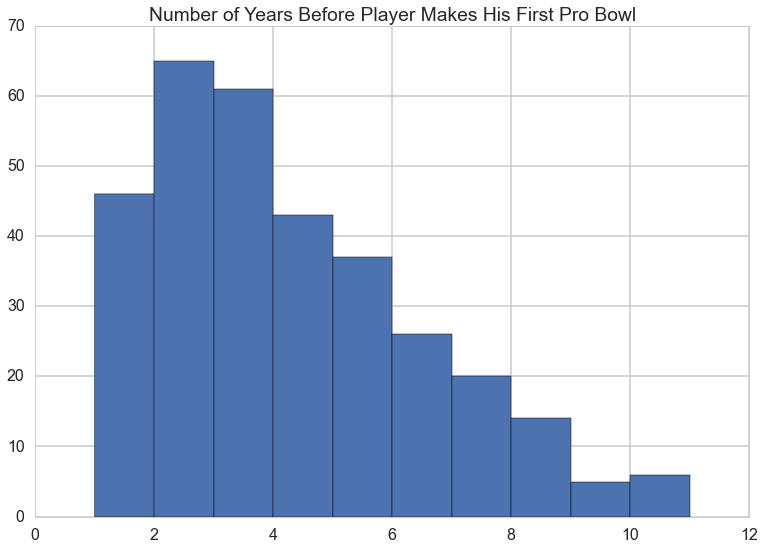

In [88]:
plt.hist(alldata[~np.isnan(alldata['yearstofirst'])]['yearstofirst'].values)
plt.title("Number of Years Before Player Makes His First Pro Bowl")

It looks like the vast majority of players who make the Pro Bowl make it within their first 5 years in the league. Let's check the actual proportion.

In [42]:
np.nanmean(alldata['yearstofirst'].values), np.nanmean(alldata[~np.isnan(alldata.yearstofirst)]['yearstofirst'].values < 6)

(3.8080495356037152, 0.7801857585139319)

So the average player makes his first Pro Bowl in his fourth year in the league, and around 80 percent of eventual Pro Bowlers make the Pro Bowl in their first 5 years. This is evidence that the issue of right-censorship, while present, can be mitigated fairly well so long as we avoid training and testing on data within the last 5 years. If we have enough data, we might consider going back 6 years. Let's compare those two options.

In [43]:
print len(alldata[alldata.year <= 2009]), len(alldata[alldata.year <= 2008])

3095 2810


So discarding 2009 would reduce our sample size by about 300 observations. Let's check the proportion of players who make the Pro Bowl past their fifth year in the league and compare to the sixth.

In [44]:
print np.nanmean(alldata[~np.isnan(alldata.yearstofirst)]['yearstofirst'].values <= 6)

0.860681114551


We see that 78 percent of players make their first Pro Bowl in their first 5 years in the league, while 86 percent make it within their first 6. That's a large enough improvement to leave out an extra year, so we will use data from 1999 to 2008 in our analysis. Let's save this as `ungrouped`.

In [45]:
ungrouped = alldata[alldata.year <= 2008]
ungrouped.head()

,Unnamed: 0,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
1813,2136,2008,Husain Abdullah,Husain,Abdullah,FS,73,204,4.63,NaN,...,16,8,NaN,NaN,NaN,0,NaN,NaN,0,0
1814,2137,2008,Jamar Adams,Jamar,Adams,SS,74,212,4.59,4.49,...,NaN,8,NaN,NaN,NaN,0,NaN,NaN,0,0
1815,2138,2008,Xavier Adibi,Xavier,Adibi,OLB,74,232,4.69,4.47,...,NaN,4,Virginia Tech,19,118,0,NaN,NaN,0,0
1816,2139,2008,Erik Ainge,Erik,Ainge,QB,78,225,4.98,4.60,...,NaN,5,Tennessee,27,162,0,NaN,NaN,0,0
1817,2140,2008,Branden Albert,Branden,Albert,OG,78,309,5.17,4.78,...,23,1,Virginia,15,15,1,2013,6,1,1


Let's take a peek to see if there are any variables with too many missing values to use for analysis.

In [46]:
ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810 entries, 1813 to 4622
Data columns (total 23 columns):
Unnamed: 0           2810 non-null int64
year                 2810 non-null int64
name                 2810 non-null object
firstname            2810 non-null object
lastname             2810 non-null object
position             2810 non-null object
heightinchestotal    2810 non-null float64
weight               2810 non-null int64
fortyyd              2807 non-null float64
twentyss             2165 non-null float64
threecone            74 non-null float64
vertical             2510 non-null float64
broad                2426 non-null float64
bench                1986 non-null float64
round                2810 non-null float64
college              1841 non-null object
pickround            1841 non-null float64
picktotal            1841 non-null float64
probowls             2810 non-null float64
firstprobowl         229 non-null float64
yearstofirst         229 non-null float64
pr

It looks like the three cone drill only has 74 observed values for almost 3000 observations. That's not particularly useful; let's discard it.

In [47]:
ungrouped.drop('threecone', axis = 1, inplace = True)
ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810 entries, 1813 to 4622
Data columns (total 22 columns):
Unnamed: 0           2810 non-null int64
year                 2810 non-null int64
name                 2810 non-null object
firstname            2810 non-null object
lastname             2810 non-null object
position             2810 non-null object
heightinchestotal    2810 non-null float64
weight               2810 non-null int64
fortyyd              2807 non-null float64
twentyss             2165 non-null float64
vertical             2510 non-null float64
broad                2426 non-null float64
bench                1986 non-null float64
round                2810 non-null float64
college              1841 non-null object
pickround            1841 non-null float64
picktotal            1841 non-null float64
probowls             2810 non-null float64
firstprobowl         229 non-null float64
yearstofirst         229 non-null float64
probowl_i            2810 non-null int64
hi

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's reset the index for this frame (since we remove a lot of entries), then save it to a csv.

In [8]:
# Define a function that will reset the index then delete the old index variable
def myreset(df):
    df.reset_index(inplace = True)
    del df['index']

myreset(ungrouped)
ungrouped.head()

,Unnamed: 0,Unnamed: 0.1,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
0,0,2136,2008,Husain Abdullah,Husain,Abdullah,FS,73,204,4.63,...,16,8,NaN,NaN,NaN,0,NaN,NaN,0,0
1,1,2137,2008,Jamar Adams,Jamar,Adams,SS,74,212,4.59,...,NaN,8,NaN,NaN,NaN,0,NaN,NaN,0,0
2,2,2138,2008,Xavier Adibi,Xavier,Adibi,OLB,74,232,4.69,...,NaN,4,Virginia Tech,19,118,0,NaN,NaN,0,0
3,3,2139,2008,Erik Ainge,Erik,Ainge,QB,78,225,4.98,...,NaN,5,Tennessee,27,162,0,NaN,NaN,0,0
4,4,2140,2008,Branden Albert,Branden,Albert,OG,78,309,5.17,...,23,1,Virginia,15,15,1,2013,6,1,1


Now let's save to a csv.

In [49]:
#ungrouped.to_csv("ungrouped.csv")

We can then run the following one-liner to reimport it.

In [50]:
ungrouped = pd.read_csv("ungrouped.csv")

### Grouped data

We also want to analyze our data by different position groups as specified before. We will now separate our ungrouped data into three different grouped files: `linedat`, `backsdat`, and `hybdat`.

In [5]:
linedat = ungrouped[ungrouped.position.isin(line)]
backsdat = ungrouped[ungrouped.position.isin(backs)]
hybdat = ungrouped[ungrouped.position.isin(hyb)]
linedat.head()

,Unnamed: 0,Unnamed: 0.1,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
4,4,2140,2008,Branden Albert,Branden,Albert,OG,78,309,5.17,...,23,1,Virginia,15,15,1,2013,6,1,1
9,9,2145,2008,Kentwan Balmer,Kentwan,Balmer,DT,77,308,5.29,...,33,1,North Carolina,29,29,0,NaN,NaN,0,1
13,13,2149,2008,Demetrius Bell,Demetrius,Bell,OT,77,303,5.25,...,9,7,Northwestern State,12,219,0,NaN,NaN,0,0
20,20,2156,2008,James Blair,James,Blair,OG,75,323,5.28,...,28,8,NaN,NaN,NaN,0,NaN,NaN,0,0
32,32,2168,2008,Duane Brown,Duane,Brown,OT,76,315,5.07,...,24,1,Virginia Tech,26,26,3,2012,5,1,1


Let's see how many observations are in each group

In [6]:
print len(linedat), len(backsdat), len(hybdat)

962 1086 582


Definitely lower in the hybrid group, but not low enough that we won't get a result.

Let's reset the index in each of these frames.

In [9]:
myreset(linedat)
myreset(backsdat)
myreset(hybdat)

##Exploratory Analysis

Now we want to do some exploration to get a sense of what we can expect when we fit a model to our data. We already saw above that only 7 percent of players make the Pro Bowl from our initial data set, which means that we'll likely have to fiddle with our rejection threshold a bit in the case of a Logistic regression. For now, let's look at the distribution of each of our predictors for both Pro Bowlers and non-Pro Bowlers and see how they compare.

In [19]:
## create an array contaning all the names of the metrics we are using
metrics = ['fortyyd', 'twentyss', 'bench', 'vertical', 'broad', 'heightinchestotal']

## create an array contaning the 3 different groups we are analyzing
groups = [backs, line, hyb]

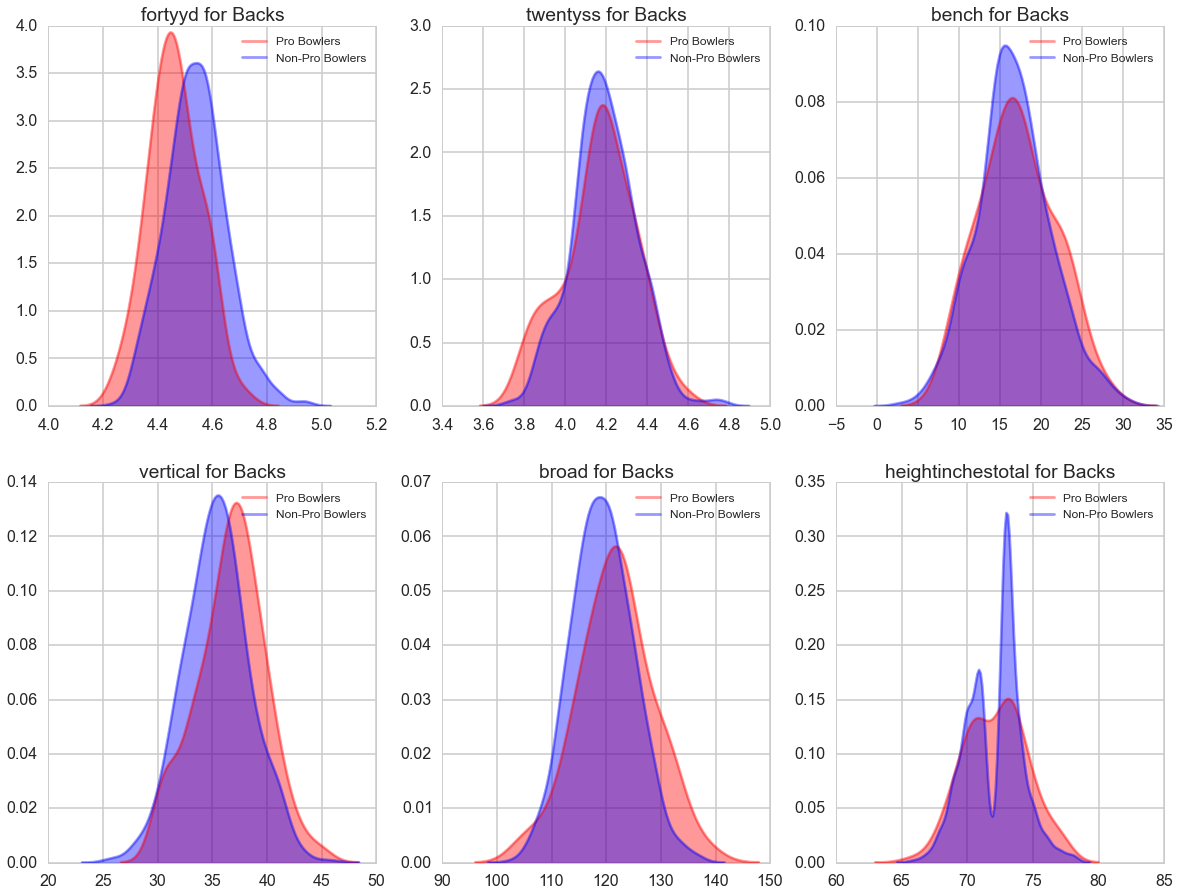

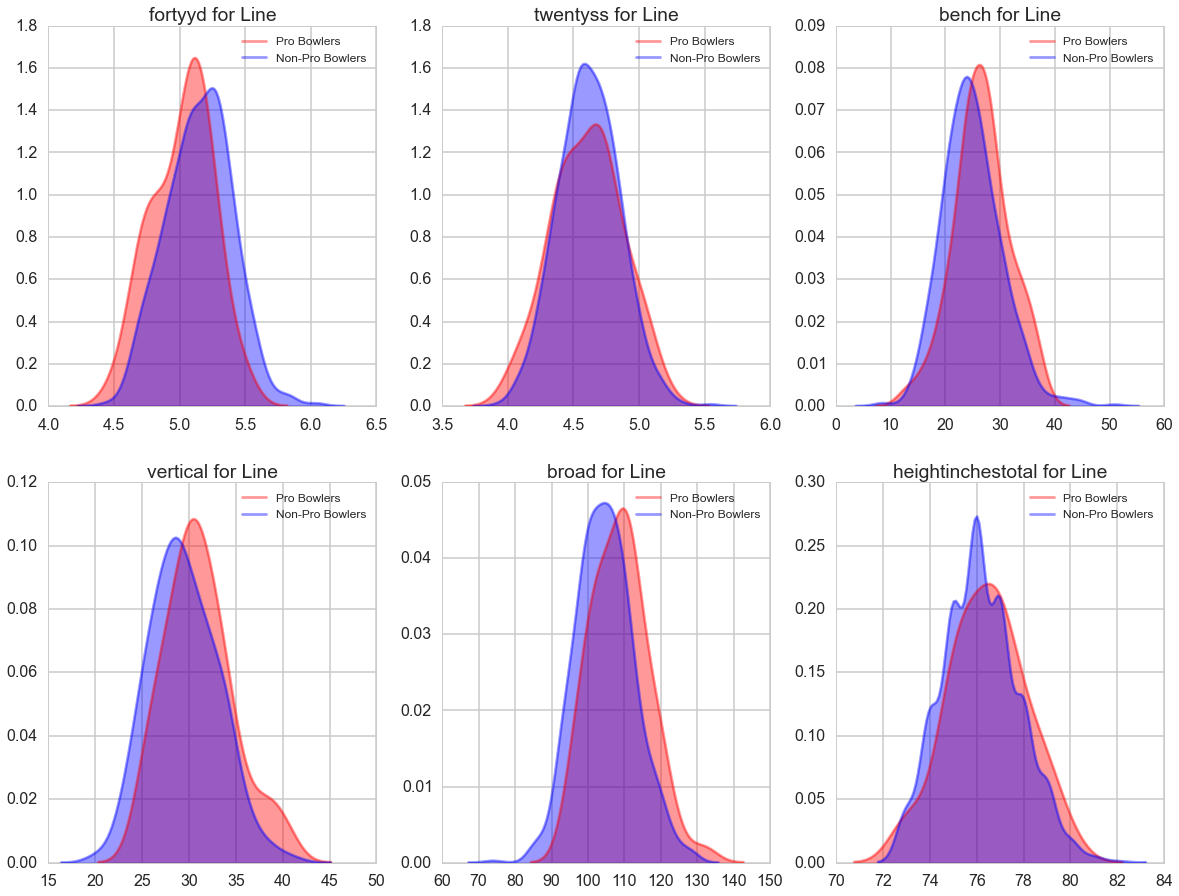

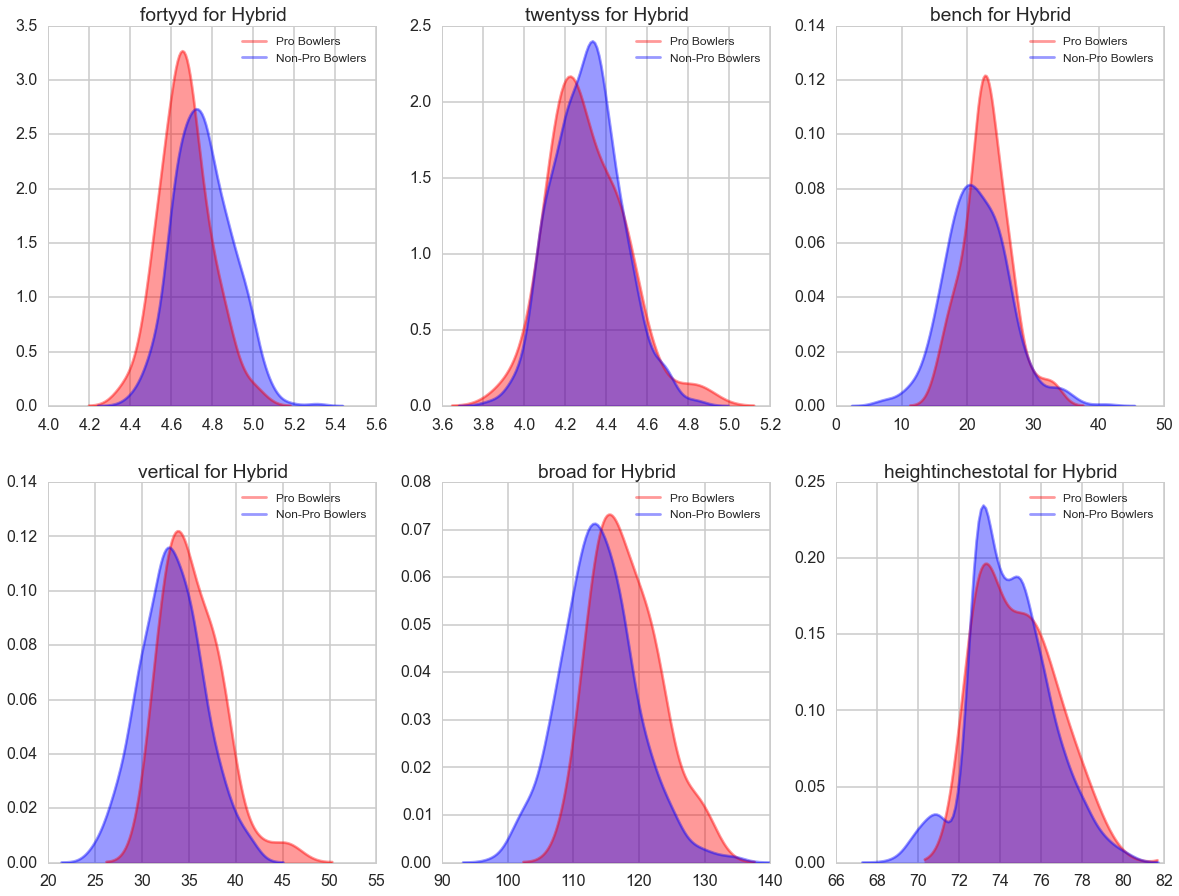

In [32]:
## we separate this plot by group since we are analyzing them separately
for group in groups:
    
    ## set group name as string
    if group == backs:
        name = 'Backs'
    elif group == line:
        name = 'Line'
    else:
        name = 'Hybrid'
    
    fig, axes = plt.subplots(figsize = (20, 15), nrows = 2, ncols = 3)
    for ax, metric in zip(axes.ravel(), metrics):

        ## set title for each metric
        ax.set_title(metric + ' for ' + name)

        ## check if there are positive values for metrics and plot them
        if not ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(group)][metric].empty:
            sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(group)][metric], ax = ax, shade=True, color='r', alpha=0.4, label="Pro Bowlers")

        ## check if there are negative values for metrics and plot them
        if not ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(group)][metric].empty:
            sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(group)][metric], ax = ax, shade=True, color='b', alpha=0.4, label="Non-Pro Bowlers")

        ## set location and size for legend
        ax.legend(loc='upper right', prop={'size':12})

It seems like for any of the three groups we can find very clear separators for the players who made the Pro Bowl versus those who did not. However, if we had to guess we would probably say that:

- the *fortyyd* metric is the best separator for the *backs*
- the *broad* metric is the best separator for the *line*
- the *fortyyd* metric is the best separator for the *hyb*

Let's isolate the best predictor for each group for use in visualization later.

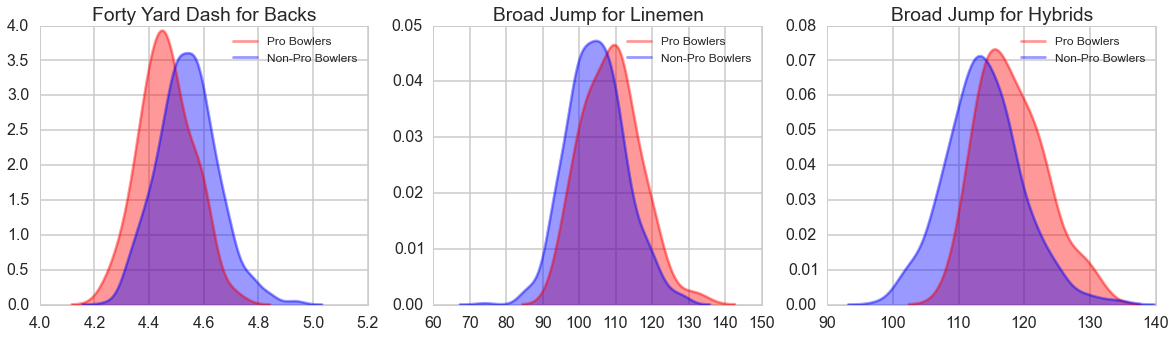

In [33]:
fig, axes = plt.subplots(figsize = (20, 5), nrows = 1, ncols = 3)
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(backs)]['fortyyd'], ax = axes[0], shade=True, color='r', alpha=0.4, label="Pro Bowlers")
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(backs)]['fortyyd'], ax = axes[0], shade=True, color='b', alpha=0.4, label="Non-Pro Bowlers")
axes[0].set_title("Forty Yard Dash for Backs")
axes[0].legend(loc='upper right', prop={'size':12})
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(line)]['broad'], ax = axes[1], shade=True, color='r', alpha=0.4, label="Pro Bowlers")
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(line)]['broad'], ax = axes[1], shade=True, color='b', alpha=0.4, label="Non-Pro Bowlers")
axes[1].set_title("Broad Jump for Linemen")
axes[1].legend(loc='upper right', prop={'size':12})
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(hyb)]['broad'], ax = axes[2], shade=True, color='r', alpha=0.4, label="Pro Bowlers")
sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(hyb)]['broad'], ax = axes[2], shade=True, color='b', alpha=0.4, label="Non-Pro Bowlers")
axes[2].set_title("Broad Jump for Hybrids")
axes[2].legend(loc='upper right', prop={'size':12})

Now let's do the same thing, but this time for first round draft picks vs non-first rounders.

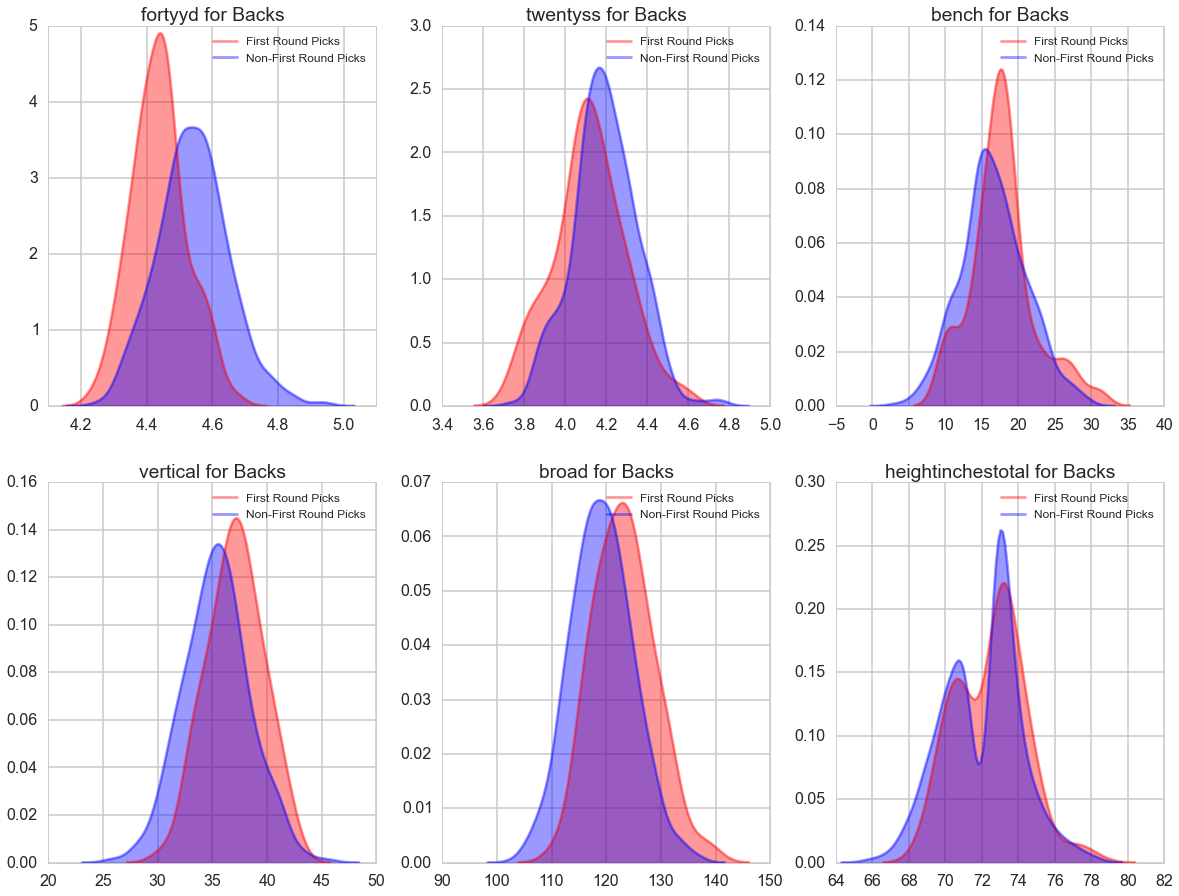

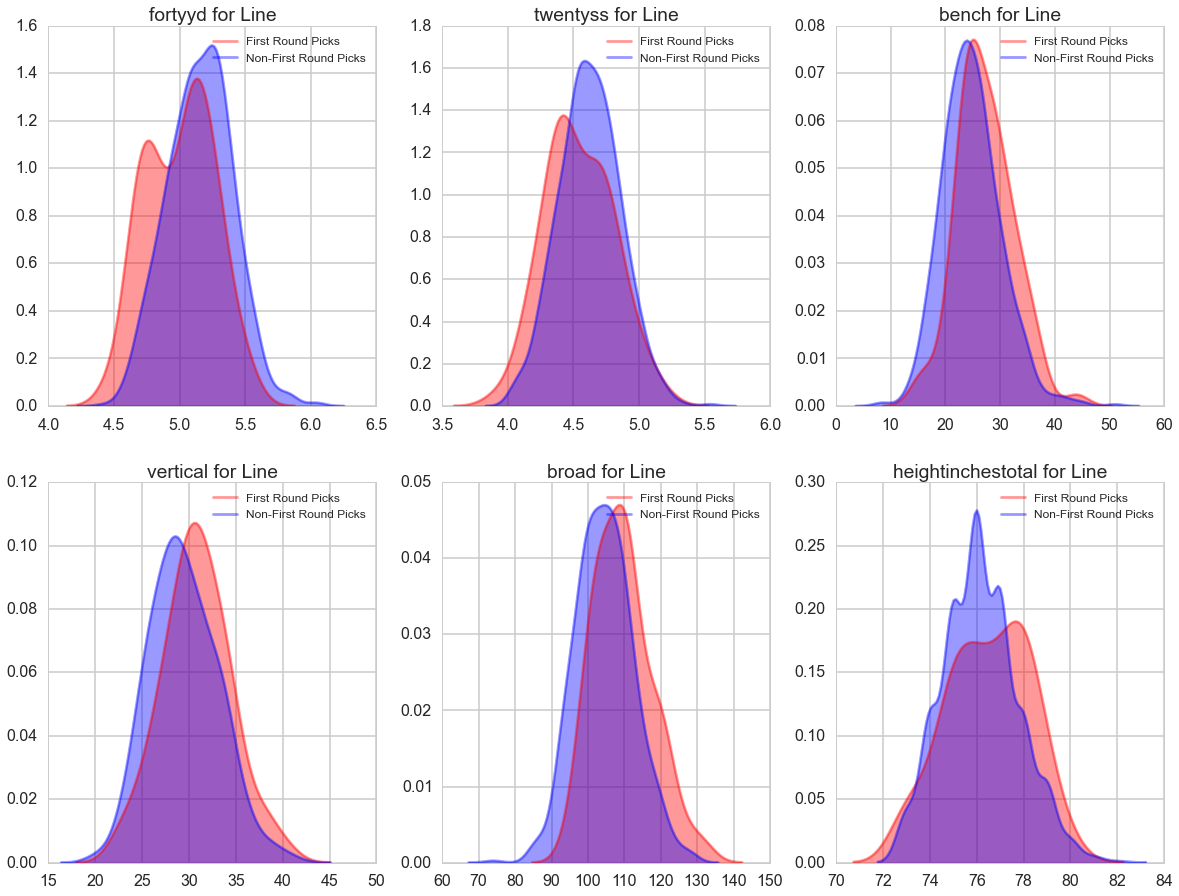

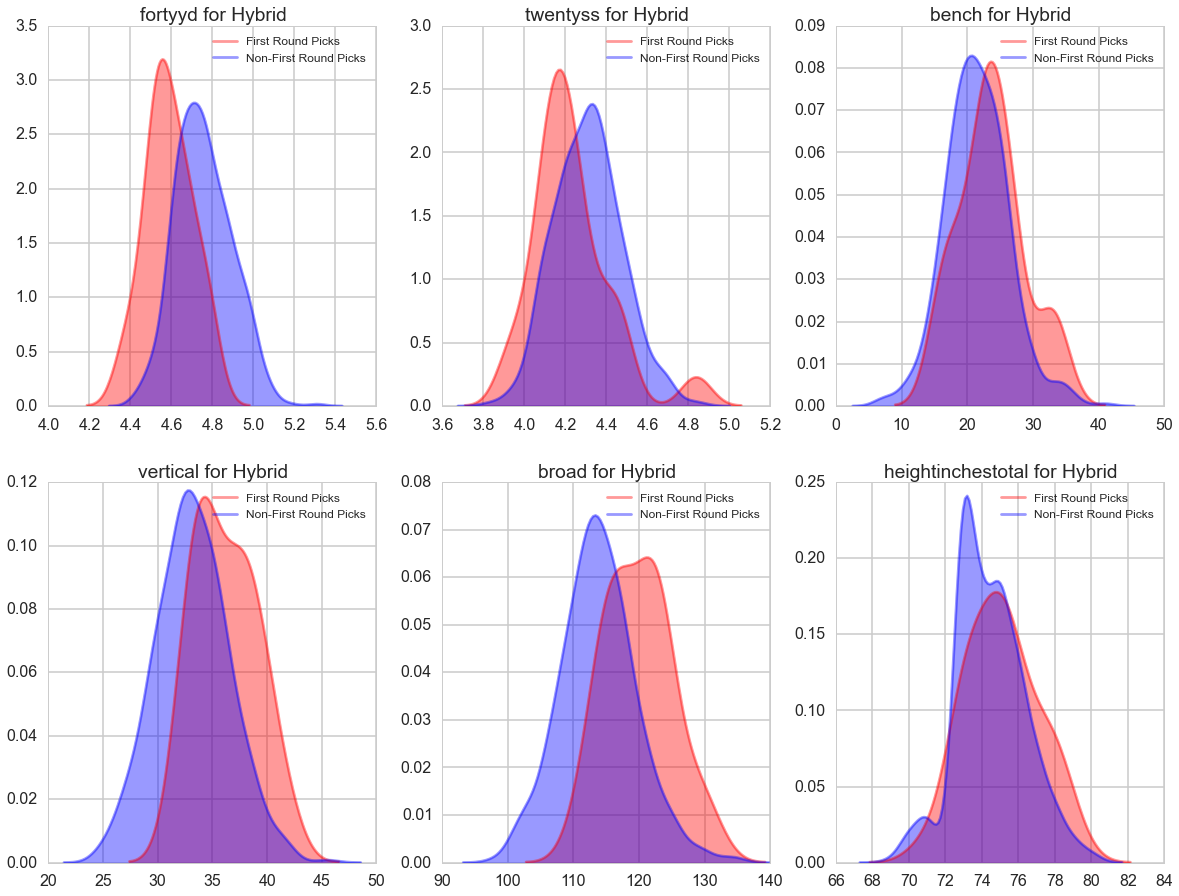

In [34]:
## we separate this plot by group since we are analyzing them separately
for group in groups:
    
    ## set group name as string
    if group == backs:
        name = 'Backs'
    elif group == line:
        name = 'Line'
    else:
        name = 'Hybrid'
    
    
    fig, axes = plt.subplots(figsize = (20, 15), nrows = 2, ncols = 3)
    for ax, metric in zip(axes.ravel(), metrics):

        ## set title for each metric
        ax.set_title(metric + ' for ' + name)

        ## check if there are positive values for metrics and plot them
        if not ungrouped[ungrouped['highpick_i'] == 1][ungrouped['position'].isin(group)][metric].empty:
            sns.kdeplot(ungrouped[ungrouped['highpick_i'] == 1][ungrouped['position'].isin(group)][metric], ax = ax, shade=True, color='r', alpha=0.4, label="First Round Picks")

        ## check if there are negative values for metrics and plot them
        if not ungrouped[ungrouped['highpick_i'] == 0][ungrouped['position'].isin(group)][metric].empty:
            sns.kdeplot(ungrouped[ungrouped['highpick_i'] == 0][ungrouped['position'].isin(group)][metric], ax = ax, shade=True, color='b', alpha=0.4, label="Non-First Round Picks")

        ## set location and size for legend
        ax.legend(loc='upper right', prop={'size':12})

Interestingly, in this case it seems like our metrics might be more promising. It seems that in all three categories the forty-yard dash is the best predictor. Let's do a plot of just the forty-yard dash.

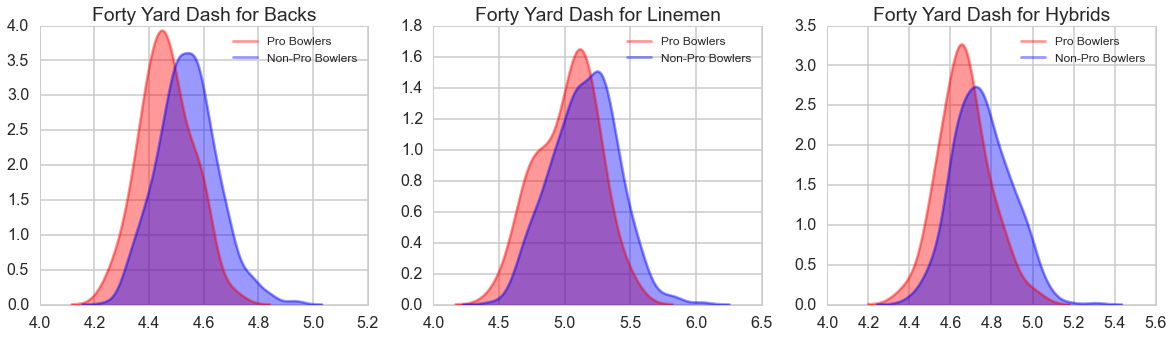

In [35]:
fig, axes = plt.subplots(figsize = (20, 5), nrows = 1, ncols = 3)
for ax, group in zip(axes.ravel(), groups):
    if group == backs:
        name = 'Backs'
    elif group == line:
        name = 'Linemen'
    else:
        name = 'Hybrids'
    sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 1][ungrouped['position'].isin(group)]['fortyyd'], ax = ax, shade=True, color='r', alpha=0.4, label="Pro Bowlers")
    sns.kdeplot(ungrouped[ungrouped['probowl_i'] == 0][ungrouped['position'].isin(group)]['fortyyd'], ax = ax, shade=True, color='b', alpha=0.4, label="Non-Pro Bowlers")
    ax.set_title("Forty Yard Dash for " + name)
    ax.legend(loc='upper right', prop={'size':12})

Let's also take a look at the confusion matrix for first round draft picks and Pro Bowlers; we want to see if being a first rounder is highly predictive of being a future Pro Bowler.

In [85]:
confusion_matrix(ungrouped['probowl_i'], ungrouped['highpick_i'])

array([[2438,  143],
       [ 128,  101]])

Unsurprisingly the bulk of our data are in the upper left corner: players who neither made the Pro Bowl nor were first round picks. But being a first round pick is clearly predictive of future success. We can see that by calculating the rate at which first rounders and non-first rounders make the Pro Bowl.

In [87]:
print 101./(101+143), 128./(128+2438)

0.41393442623 0.049883086516


Over 40 percent of first rounders eventually make a Pro Bowl, while only 5 percent of non-first rounders ever do. This indicates that teams are already doing a pretty good job of predicting which players will be good. Can we do better?

##Modeling

We now want to model our data. Since we are looking at binary outcomes, our plan was to do three different kinds of models.

1. Logistic Regression. This has the benefit of producing actual probabilities; we have a very low rate of making the Pro Bowl, so we can adjust our acceptance threshold in order to improve our model.
2. Support Vector Machine. Similar to a logistic regression, so it's worth trying out. Only downside is that it doesn't produce actual probabilities. If they produce similar results, we will favor the logistic model.
3. Random Forest. We had planned to do this so that we could use position as a predictor rather than fit separate models for specific groups. Unfortunately, scikit-learn's random forest classifier apparently doesn't accept categorical variables, so we decided to focus on the logistic regression and SVM.

### Train-Test Split and Missing Values

We now want to split our data sets into training and testing. We will do separate splits for each of the different grouped cases and use those splits to come up with our train-test split for the ungrouped case. First let's decide which rows will be in train/test for each data set. Since the indices don't start at 0, we must use the actual index values from each frame.

In [82]:
from sklearn.cross_validation import train_test_split
trsz = 0.7
itrainback, itestback = train_test_split(xrange(backsdat.shape[0]), train_size = trsz)
itrainline, itestline = train_test_split(xrange(linedat.shape[0]), train_size = trsz)
itrainhyb, itesthyb = train_test_split(xrange(hybdat.shape[0]), train_size = trsz)
itrainall = itrainback + itrainline + itrainhyb
itestall = itestback + itestline + itesthyb

Now we want to create an array for each of the three groups with trues for training data and falses for the testing data. We can write a short function called `mask` that will make this easier.

In [83]:
# This function takes in a list of training and test indices, along with the corresponding data frame, 
# and returns a true-false array.
def mask(itrain, itest, df):
    mask = np.ones(df.shape[0], dtype = 'int')
    mask[itrain] = 1
    mask[itest] = 0
    return (mask == 1)

Now we can use this to get booleans for training and testing, which will come in handy for handling missing values.

In [84]:
bmask = mask(itrainback, itestback, backsdat)
lmask = mask(itrainline, itestline, linedat)
hmask = mask(itrainhyb, itesthyb, hybdat)
bmask

array([ True, False, False, ...,  True,  True, False], dtype=bool)

Let's ensure that we didn't get unlucky with our split and check the proportion of Pro Bowlers and first round picks in each.

In [85]:
print np.mean(backsdat.loc[bmask, 'probowl_i']), np.mean(backsdat.loc[~bmask, 'probowl_i'])
print np.mean(backsdat.loc[bmask, 'highpick_i']), np.mean(backsdat.loc[~bmask, 'highpick_i'])
print np.mean(linedat.loc[lmask, 'probowl_i']), np.mean(linedat.loc[~lmask, 'probowl_i'])
print np.mean(linedat.loc[lmask, 'highpick_i']), np.mean(linedat.loc[~lmask, 'highpick_i'])
print np.mean(hybdat.loc[hmask, 'probowl_i']), np.mean(hybdat.loc[~hmask, 'probowl_i'])
print np.mean(hybdat.loc[hmask, 'highpick_i']), np.mean(hybdat.loc[~hmask, 'highpick_i'])

0.0921052631579 0.079754601227
0.0907894736842 0.0736196319018
0.0817236255572 0.0588235294118
0.102526002972 0.083044982699
0.0761670761671 0.0628571428571
0.044226044226 0.0685714285714


Nothing looks too out of the ordinary, so it seems that we can proceed.

Now we want to standardize all of our data sets. We will standardize only the variables of potential interest. This includes the five exercises we're left with, along with height and weight.

In order to do this, however, we will need to do something about missing values. We don't want to drop players with missing values, because most of them are likely only missing one exercise. If we had more time we would consider something like multiple imputation, but for simplicity we will impute the training mean for every missing value. In the logistic regression case, this is nice because it means the imputed value has no effect on the predicted probability of making the Pro Bowl or being a high draft pick; we will impute a standardized value of 0.

First let's write a function which returns a dictionary of training means for a list of variables given a data frame and booleans indicating which variables are in the training set.

In [86]:
def trainmeans(varlist, df, mask):
    meandict = {}
    for var in varlist:
        meandict[var] = np.mean(df[mask][var])
    return meandict

Now we store the list of variables names we want training means for and find the training means for each of our three data frames.

In [87]:
PREDICTORS = ['fortyyd', 'bench', 'vertical', 'broad', 'twentyss', 'heightinchestotal', 'weight']
btmeans = trainmeans(PREDICTORS, backsdat, bmask)
ltmeans = trainmeans(PREDICTORS, linedat, lmask)
htmeans = trainmeans(PREDICTORS, hybdat, hmask)
btmeans

{'bench': 0.06942534956281761,
 'broad': 0.0456955214978589,
 'fortyyd': -0.03986980511656167,
 'heightinchestotal': -0.022268008831033394,
 'twentyss': -0.04073074494468071,
 'vertical': 0.038251667140373515,
 'weight': -0.025821078328004687}

Finally, for each of our data sets and each of our variables, we will impute the mean.

In [88]:
for var in PREDICTORS:
    backsdat[var].fillna(btmeans[var], inplace = True)
    linedat[var].fillna(ltmeans[var], inplace = True)
    hybdat[var].fillna(htmeans[var], inplace = True)
    
hybdat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 581
Data columns (total 23 columns):
Unnamed: 0           582 non-null int64
Unnamed: 0.1         582 non-null int64
year                 582 non-null int64
name                 582 non-null object
firstname            582 non-null object
lastname             582 non-null object
position             582 non-null object
heightinchestotal    582 non-null float64
weight               582 non-null float64
fortyyd              582 non-null float64
twentyss             582 non-null float64
vertical             582 non-null float64
broad                582 non-null float64
bench                582 non-null float64
round                582 non-null float64
college              376 non-null object
pickround            376 non-null float64
picktotal            376 non-null float64
probowls             582 non-null float64
firstprobowl         42 non-null float64
yearstofirst         42 non-null float64
probowl_i            582 n

Perfect, all of the missing values for our predictors are gone. Now we can standardize our data. First let's write a function that can do it, then run that function on each of our three data sets.

In [89]:
from sklearn.preprocessing import StandardScaler
def mystandardizer(df, mask, preds):
    scaler = StandardScaler().fit(df[mask][preds])
    df[preds] = scaler.transform(df[preds])
    return None

mystandardizer(backsdat, bmask, PREDICTORS)
mystandardizer(linedat, lmask, PREDICTORS)
mystandardizer(hybdat, hmask, PREDICTORS)
backsdat.head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unnamed: 0,Unnamed: 0.1,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
0,0,2136,2008,Husain Abdullah,Husain,Abdullah,FS,0.445302,0.128170,0.874652,...,-0.218810,8,NaN,NaN,NaN,0,NaN,NaN,0,0
1,1,2137,2008,Jamar Adams,Jamar,Adams,SS,0.921209,0.662650,0.518578,...,-0.067499,8,NaN,NaN,NaN,0,NaN,NaN,0,0
2,6,2142,2008,Anthony Alridge,Anthony,Alridge,RB,-1.458327,-2.143371,-1.528852,...,-0.067499,8,NaN,NaN,NaN,0,NaN,NaN,0,0
3,7,2143,2008,Donnie Avery,Donnie,Avery,WR,-0.506512,-0.673551,-0.905721,...,-0.218810,2,Houston,2,33,0,NaN,NaN,0,0
4,10,2146,2008,Dominique Barber,Dominique,Barber,FS,0.445302,0.529030,1.319746,...,1.725139,6,Minnesota,7,173,0,NaN,NaN,0,0


Looking at earlier results, we see that Husain Abdullah initally had a missing value for `twentyss`, but it is now effectively a standardized 0, which is exactly what we wanted. Imputing the missing values means that we have underestimated the standard error; we will ignore this issue.

### Train SVMs on grouped data sets for making Pro Bowl

In [90]:
from sklearn.svm import LinearSVC

Now we set up a classifier using LinearSVC to implement a linear SVM:

In [91]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

## for backs
Xmatrix_backs = backsdat[PREDICTORS].values
Yresp_backs = backsdat['probowl_i'].values

## for line
Xmatrix_line = linedat[PREDICTORS].values
Yresp_line = linedat['probowl_i'].values

# for hyb
Xmatrix_hyb = hybdat[PREDICTORS].values
Yresp_hyb = hybdat['probowl_i'].values

In [92]:
## for backs
Xmatrix_backs_train = Xmatrix_backs[bmask]
Xmatrix_backs_test = Xmatrix_backs[~bmask]
Yresp_backs_train = Yresp_backs[bmask]
Yresp_backs_test = Yresp_backs[~bmask]

## for line
Xmatrix_line_train = Xmatrix_line[lmask]
Xmatrix_line_test = Xmatrix_line[~lmask]
Yresp_line_train = Yresp_line[lmask]
Yresp_line_test = Yresp_line[~lmask]

## for hyb
Xmatrix_hyb_train = Xmatrix_hyb[hmask]
Xmatrix_hyb_test = Xmatrix_hyb[~hmask]
Yresp_hyb_train = Yresp_hyb[hmask]
Yresp_hyb_test = Yresp_hyb[~hmask]

Now we use GridSearchCV over the parameter grid of regularization coefficients in the Cs array to get the best fit classifier using 5-fold cross validation. We try to find out what are the best values of C to choose in each case and also investigate the accuracy. For each group, we store the best classifier in a separate variable best_group

In [93]:
from sklearn.grid_search import GridSearchCV

## set parameters in dictionary format
parameters = {"C": Cs}

## run GridSearch
gs = GridSearchCV(estimator=clfsvm, param_grid=parameters, cv=5)

## for backs

## fit
gs.fit(Xmatrix_backs_train, Yresp_backs_train)

## save best estimator to variable best
best_backs = gs.best_estimator_

print "BEST_backs", gs.best_params_

## for line

## fit
gs.fit(Xmatrix_line_train, Yresp_line_train)

## save best estimator to variable best
best_line = gs.best_estimator_

print "BEST_line", gs.best_params_

## for hyb

## fit
gs.fit(Xmatrix_hyb_train, Yresp_hyb_train)

## save best estimator to variable best
best_hyb = gs.best_estimator_

print "BEST_hyb", gs.best_params_

BEST_backs {'C': 0.001}
BEST_line {'C': 0.001}
BEST_hyb {'C': 0.01}


We then fit the data again with each best classifier, and report on the accuracy of this classifier:

In [94]:
## for backs

## fit data with best estimator
clfsvm_backs = best_backs.fit(Xmatrix_backs_train, Yresp_backs_train)

## get accuracy
training_accuracy_backs = clfsvm_backs.score(Xmatrix_backs_train, Yresp_backs_train)

## print accuracy
print "Accuracy on training backs data: %f" % (training_accuracy_backs)

## for line

## fit data with best estimator
clfsvm_line = best_line.fit(Xmatrix_line_train, Yresp_line_train)

## get accuracy
training_accuracy_line = clfsvm_line.score(Xmatrix_line_train, Yresp_line_train)

## print accuracy
print "Accuracy on training line data: %f" % (training_accuracy_line)

## for hyb

## fit data with best estimator
clfsvm_hyb = best_hyb.fit(Xmatrix_hyb_train, Yresp_hyb_train)

## get accuracy
training_accuracy_hyb = clfsvm_hyb.score(Xmatrix_hyb_train, Yresp_hyb_train)

## print accuracy
print "Accuracy on training hyb data: %f" % (training_accuracy_hyb)

Accuracy on training backs data: 0.907895
Accuracy on training line data: 0.918276
Accuracy on training hyb data: 0.923833


In [95]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
#your code here

## credits to lab 6

def cv_optimize (clf, parameters, X, y, n_folds, score_func):
    
    ## if score_func exists, apply it to GridSearchCV
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
        
    ## otherwise, just use its standard form
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)

    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [96]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [97]:
%%time

## for backs

print "*********"
print "Results for backs"
clfsvm_backs, Xtrain_backs_svm, ytrain_backs_svm, Xtest_backs_svm, ytest_backs_svm = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, backsdat, PREDICTORS, 'probowl_i', 1, mask=bmask)
print "*********"

print "*********"
print "Results for line"
clfsvm_line, Xtrain_line_svm, ytrain_line_svm, Xtest_line_svm, ytest_line_svm = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, linedat, PREDICTORS, 'probowl_i', 1, mask=lmask)
print "*********"

print "*********"
print "Results for hyb"
clfsvm_hyb, Xtrain_hyb_svm, ytrain_hyb_svm, Xtest_hyb_svm, ytest_hyb_svm = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, hybdat, PREDICTORS, 'probowl_i', 1, mask=hmask)
print "*********"

*********
Results for backs
using mask
BEST {'C': 0.001} 0.907894736842 [mean: 0.90789, std: 0.00000, params: {'C': 0.001}, mean: 0.90789, std: 0.00000, params: {'C': 0.01}, mean: 0.90789, std: 0.00000, params: {'C': 0.1}, mean: 0.90789, std: 0.00000, params: {'C': 1.0}, mean: 0.90789, std: 0.00000, params: {'C': 10.0}, mean: 0.90789, std: 0.00000, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[300   0]
 [ 26   0]]
########################################################
*********
*********
Results for line
using mask
BEST {'C': 0.001} 0.918276374443 [mean: 0.91828, std: 0.00030, params: {'C': 0.001}, mean: 0.91828, std: 0.00030, params: {'C': 0.01}, mean: 0.91828, std: 0.00030, params: {'C': 0.1}, mean: 0.91828, std: 0.00030, params: {'C': 1.0}, mean: 0.91828, std: 0.00030, params: {'C': 10.0}, mean: 0.91828, std: 0.00030, params: {'C': 100.0}]
############# based on standard predict ####

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


This is a problem, but not an entirely unexpected one: our model is predicting every observation as a non-Pro Bowler. This makes sense given our low rate of making the Pro Bowl, our small sample size, and our exploratory analysis indicating that we probably wouldn't have very high predictive power. Since we're more sure of how to address these issues with logistic regression than with SVM, we are going to focus on the logistic regression.

In [98]:
## for backs
reuse_split_backs = dict(Xtrain=Xtrain_backs_svm, Xtest=Xtest_backs_svm, ytrain=ytrain_backs_svm, ytest=ytest_backs_svm)

## for line
reuse_split_line = dict(Xtrain=Xtrain_line_svm, Xtest=Xtest_line_svm, ytrain=ytrain_line_svm, ytest=ytest_line_svm)

## for hyb
reuse_split_hyb = dict(Xtrain=Xtrain_hyb_svm, Xtest=Xtest_hyb_svm, ytrain=ytrain_hyb_svm, ytest=ytest_hyb_svm)

### Logistic Regression for Pro Bowl

In [99]:
from sklearn.linear_model import LogisticRegression

## set parameters
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

## for backs

print "********"
print "Results for backs"

## run do_classify again
clflog_backs, Xtrain_backs_log, ytrain_backs_log, Xtest_backs_log, ytest_backs_log = do_classify(LogisticRegression(penalty="l2"), parameters, backsdat, PREDICTORS, 'probowl_i', 1, reuse_split=reuse_split_backs)

print "********"

## for line

print "********"
print "Results for line"

## run do_classify again
clflog_line, Xtrain_line_log, ytrain_line_log, Xtest_line_log, ytest_line_log = do_classify(LogisticRegression(penalty="l2"), parameters, linedat, PREDICTORS, 'probowl_i', 1, reuse_split=reuse_split_line)

print "********"

## for hyb

print "********"
print "Results for hyb"

## run do_classify again
clflog_hyb, Xtrain_hyb_log, ytrain_hyb_log, Xtest_hyb_log, ytest_hyb_log = do_classify(LogisticRegression(penalty="l2"), parameters, hybdat, PREDICTORS, 'probowl_i', 1, reuse_split=reuse_split_hyb)

print "********"

********
Results for backs
using reuse split
BEST {'C': 0.001} 0.907894736842 [mean: 0.90789, std: 0.00000, params: {'C': 0.001}, mean: 0.90789, std: 0.00000, params: {'C': 0.01}, mean: 0.90789, std: 0.00000, params: {'C': 0.1}, mean: 0.90789, std: 0.00000, params: {'C': 1}, mean: 0.90658, std: 0.00263, params: {'C': 10}, mean: 0.90658, std: 0.00263, params: {'C': 100}, mean: 0.90658, std: 0.00263, params: {'C': 1000}, mean: 0.90658, std: 0.00263, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[300   0]
 [ 26   0]]
########################################################
********
********
Results for line
using reuse split
BEST {'C': 0.001} 0.918276374443 [mean: 0.91828, std: 0.00030, params: {'C': 0.001}, mean: 0.91828, std: 0.00030, params: {'C': 0.01}, mean: 0.91828, std: 0.00030, params: {'C': 0.1}, mean: 0.91828, std: 0.00469, params: {'C': 1}, mean: 0.91828, std: 0.00469, params: {'C'

Given that only 7 percent of our sample made a Pro Bowl, this result isn't surprising; we should expect all of our probabilities to be below 50 percent. If we want to actually predict some Pro Bowlers, we will need to play with the rejection threshold. First we will reuse a function from homework 3 that allows us to do this for the logistic regression model.

In [100]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

Now we can generate a new confusion matrix for each data set. Before we do that, it makes sense to think about whether we want to overpredict or underpredict future Pro Bowlers. That is, we want to have a rough conception of our utility matrix.

For true negatives, a team gains ever so slightly; it doesn't spend a high draft pick on a player who won't actually live up to expectations, but it also isn't guaranteed to use that pick on a player who actually does well.

For false negatives, the cost is much higher; the team failed to see that a player would be very good and so lost out on valuable contributions by not drafting them.

For false positives, the cost is slightly more than for true negatives, because the team actually used the draft pick on a player who wasn't that good. But given the low rate of Pro Bowl-caliber players, they can't reasonably expect that their pick would've brought them a very good player to begin with.

True positives should see the largest impact; the team got a very valuable contributer.

So we would rather falsely predict a player to be a Pro Bowler than to falsely predict they won't be. Let's start with a rejection threshold of 10 percent and see what happens.

####Backs model for Pro Bowlers

In [101]:
ybacks_repred = t_repredict(clflog_backs, .1, Xtest_backs_log)

In [102]:
confusion_matrix(ytest_backs_log, ybacks_repred)

array([[  0, 300],
       [  0,  26]])

By this threshold we have a true positive rate of 75 percent, which is quite good. Our test set sample size isn't so big, so we need to make sure we don't overstate our results, but these results are more promising than what we saw before. Let's compare our model's predictions to how well NFL teams do.

In [103]:
confusion_matrix(backsdat['probowl_i'], backsdat['highpick_i'])

array([[940,  50],
       [ 53,  43]])

In [104]:
confusion_matrix(backsdat['probowl_i'], t_repredict(clflog_backs, .1, backsdat[PREDICTORS]))

array([[  0, 990],
       [  0,  96]])

Our model has made a trade-off, predicting a lot of false positives in favor of catching more true positives. Let's see if we can't adjust our rejection threshold to see how our model compares with an analogous number of true negatives. This is a logical way to compare our model's performance to that of NFL talent evaluators, i.e. those who determine which players are worth high draft picks. We are adjusting our model's true negative rate to equal that of NFL evaluators', and we will compare their true positive rates.

In [142]:
confusion_matrix(backsdat['probowl_i'], t_repredict(clflog_backs, .45368, backsdat[PREDICTORS]))

array([[940,  50],
       [ 74,  22]])

We can see that our model does worse than NFL teams currently do, which isn't surprising; NFL teams consider many more things than just the Scouting Combine, so they have more information at their disposal than we do.

Let's take a look at the prediction probabilities and plot histograms of their distributions for Pro Bowlers and non-Pro Bowlers.

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


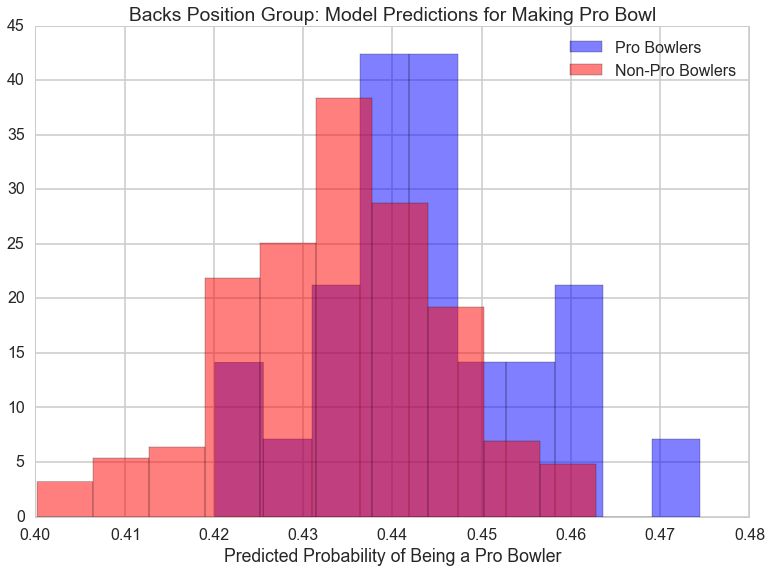

In [106]:
backsprobs = [x[1] for x in clflog_backs.predict_proba(Xtest_backs_log)]
backstest = backsdat[~bmask]
backstest['lprob'] = backsprobs
fig, ax = plt.subplots()
ax.hist(backstest[backstest.probowl_i == 1]['lprob'].values, color = 'b', label = 'Pro Bowlers', alpha = .5, normed=True)
ax.hist(backstest[backstest.probowl_i == 0]['lprob'].values, color = 'r', label = 'Non-Pro Bowlers', alpha = .5, normed = True)
ax.legend()
ax.set_xlabel("Predicted Probability of Being a Pro Bowler")
ax.set_title("Backs Position Group: Model Predictions for Making Pro Bowl")

That's weird; why are our probabilities centered around .44? There is also a lot of overlap between the Pro Bowl and non-Pro Bowl groups, suggesting very modest predictive ability, if any.

In [107]:
PREDICTORS

['fortyyd',
 'bench',
 'vertical',
 'broad',
 'twentyss',
 'heightinchestotal',
 'weight']

In [108]:
clflog_backs.coef_

array([[-0.03672715,  0.00385215,  0.0195982 ,  0.00865767,  0.00017422,
         0.00041691,  0.0123591 ]])

It looks like the forty yard dash and bench press are the most important predictors for backs. However, the coefficient sizes are so low for all of them that none of these effects are likely to be significant considering our sample size.

####Comparable results for line and hybrid groups

In [109]:
yline_repred = t_repredict(clflog_line, .445, Xtest_line_log)
yhyb_repred = t_repredict(clflog_hyb, .3, Xtest_hyb_log)

In [110]:
confusion_matrix(ytest_line_log, yline_repred)

array([[201,  71],
       [  9,   8]])

In [111]:
confusion_matrix(ytest_hyb_log, yhyb_repred)

array([[163,   1],
       [ 11,   0]])

Here our results are less promising; both of our confusion matrices are very sensitive to the slightest change in threshold. Let's again compare our models' predictive ability to NFL teams' evaluations.

In [112]:
confusion_matrix(linedat['probowl_i'], linedat['highpick_i'])

array([[827,  63],
       [ 42,  30]])

In [149]:
confusion_matrix(linedat['probowl_i'], t_repredict(clflog_line, .4541, linedat[PREDICTORS]))

array([[827,  63],
       [ 58,  14]])

In [114]:
confusion_matrix(hybdat['probowl_i'], hybdat['highpick_i'])

array([[526,  14],
       [ 26,  16]])

In [154]:
confusion_matrix(hybdat['probowl_i'], t_repredict(clflog_hyb, .25, hybdat[PREDICTORS]))

array([[526,  14],
       [ 39,   3]])

Once again, our model does a worse job than NFL evaluators do. Let's plot analogous histograms of the prediction probabilities from before.

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


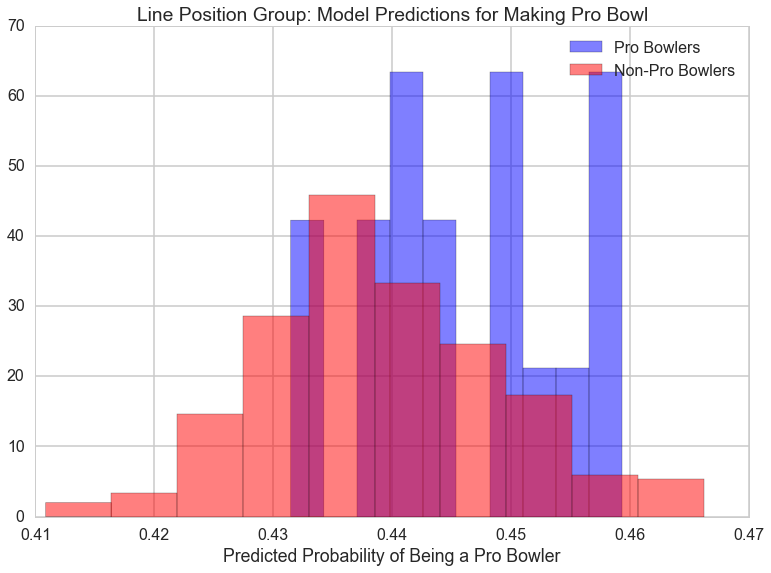

In [116]:
lineprobs = [x[1] for x in clflog_line.predict_proba(Xtest_line_log)]
linetest = linedat[~lmask]
linetest['lprob'] = lineprobs
fig, ax = plt.subplots()
ax.hist(linetest[linetest.probowl_i == 1]['lprob'].values, color = 'b', label = 'Pro Bowlers', alpha = .5, normed=True)
ax.hist(linetest[linetest.probowl_i == 0]['lprob'].values, color = 'r', label = 'Non-Pro Bowlers', alpha = .5, normed = True)
ax.legend()
ax.set_xlabel("Predicted Probability of Being a Pro Bowler")
ax.set_title("Line Position Group: Model Predictions for Making Pro Bowl")

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


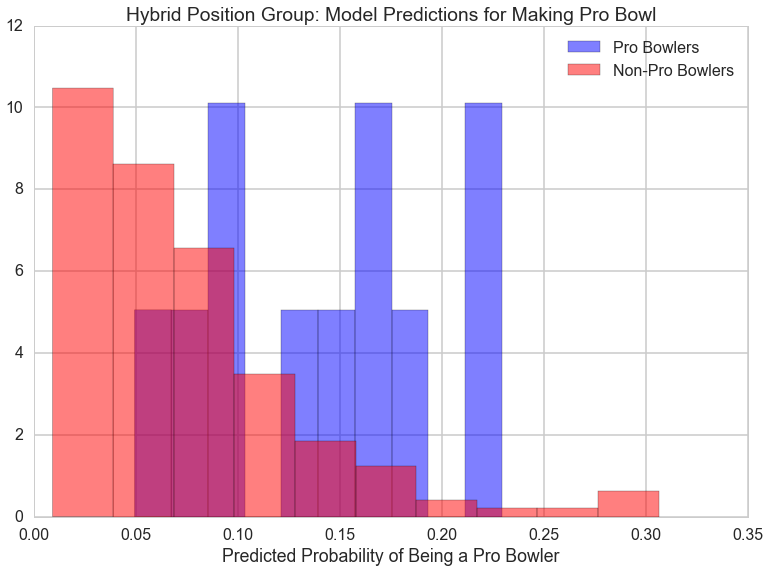

In [117]:
hybprobs = [x[1] for x in clflog_hyb.predict_proba(Xtest_hyb_log)]
hybtest = hybdat[~hmask]
hybtest['lprob'] = hybprobs
fig, ax = plt.subplots()
ax.hist(hybtest[hybtest.probowl_i == 1]['lprob'].values, color = 'b', label = 'Pro Bowlers', alpha = .5, normed=True)
ax.hist(hybtest[hybtest.probowl_i == 0]['lprob'].values, color = 'r', label = 'Non-Pro Bowlers', alpha = .5, normed = True)
ax.legend()
ax.set_xlabel("Predicted Probability of Being a Pro Bowler")
ax.set_title("Hybrid Position Group: Model Predictions for Making Pro Bowl")

We see similar results to before: our models are only doing modestly well at assigning higher probabilities to true Pro Bowlers.

###Logistic Regressions for Predicting First Round picks

We now want to run logistic regressions on these groups again, but this time with the response being whether or not the player was a first round pick. Then we will compare the coefficients from these models to the models predicting Pro Bowlers to see if NFL teams are evaluating the Combine in a way that is predictive of success.

In [118]:
## for backs

print "********"
print "Results for backs"

## run do_classify again
clflog_backs2, Xtrain_backs_log, ytrain_backs_log, Xtest_backs_log, ytest_backs_log = do_classify(LogisticRegression(penalty="l2"), parameters, backsdat, PREDICTORS, 'highpick_i', 1, reuse_split=reuse_split_backs)

print "********"

## for line

print "********"
print "Results for line"

## run do_classify again
clflog_line2, Xtrain_line_log, ytrain_line_log, Xtest_line_log, ytest_line_log = do_classify(LogisticRegression(penalty="l2"), parameters, linedat, PREDICTORS, 'highpick_i', 1, reuse_split=reuse_split_line)

print "********"

## for hyb

print "********"
print "Results for hyb"

## run do_classify again
clflog_hyb2, Xtrain_hyb_log, ytrain_hyb_log, Xtest_hyb_log, ytest_hyb_log = do_classify(LogisticRegression(penalty="l2"), parameters, hybdat, PREDICTORS, 'highpick_i', 1, reuse_split=reuse_split_hyb)

print "********"

********
Results for backs
using reuse split
BEST {'C': 0.001} 0.907894736842 [mean: 0.90789, std: 0.00000, params: {'C': 0.001}, mean: 0.90789, std: 0.00000, params: {'C': 0.01}, mean: 0.90789, std: 0.00000, params: {'C': 0.1}, mean: 0.90789, std: 0.00000, params: {'C': 1}, mean: 0.90658, std: 0.00263, params: {'C': 10}, mean: 0.90658, std: 0.00263, params: {'C': 100}, mean: 0.90658, std: 0.00263, params: {'C': 1000}, mean: 0.90658, std: 0.00263, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[300   0]
 [ 26   0]]
########################################################
********
********
Results for line
using reuse split
BEST {'C': 0.001} 0.918276374443 [mean: 0.91828, std: 0.00030, params: {'C': 0.001}, mean: 0.91828, std: 0.00030, params: {'C': 0.01}, mean: 0.91828, std: 0.00030, params: {'C': 0.1}, mean: 0.91828, std: 0.00469, params: {'C': 1}, mean: 0.91828, std: 0.00469, params: {'C'

Let's take a look at the coefficients from each.

In [119]:
clflog_backs2.coef_

array([[-0.03672715,  0.00385215,  0.0195982 ,  0.00865767,  0.00017422,
         0.00041691,  0.0123591 ]])

In [120]:
clflog_backs.coef_

array([[-0.03672715,  0.00385215,  0.0195982 ,  0.00865767,  0.00017422,
         0.00041691,  0.0123591 ]])

In [121]:
clflog_line2.coef_

array([[-0.02109296,  0.01431839,  0.0149736 ,  0.01449809,  0.00388652,
         0.00626947,  0.00582626]])

In [122]:
clflog_line.coef_

array([[-0.02109296,  0.01431839,  0.0149736 ,  0.01449809,  0.00388652,
         0.00626947,  0.00582626]])

In [155]:
clflog_hyb2.coef_

array([[-0.42602282,  0.13826819,  0.27264195,  0.3144182 ,  0.18892698,
        -0.11202301,  0.46574617]])

In [156]:
clflog_hyb.coef_

array([[-0.42602282,  0.13826819,  0.27264195,  0.3144182 ,  0.18892698,
        -0.11202301,  0.46574617]])

The coefficients from the high draft pick model are exactly equal to the coefficients from the Pro Bowl model in every case. That means one of two things: we made a mistake in coding our data, or NFL teams are doing a pretty good job of using the Combine to predict NFL success. Let's double check to make sure we didn't make a mistake in our data.

In [157]:
np.mean(ungrouped.probowl_i == ungrouped.highpick_i)

0.90355871886120998

Our two variables are very highly correlated, but they're not exactly equal. It's possible that our small sample sizes are leading to these results, but it's also likely that NFL teams are already doing a good job of using the Scouting Combine to evaluate players.

## ROC Curve

In [123]:
from sklearn.metrics import roc_curve, auc

In [124]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

#### Results for each position grouping

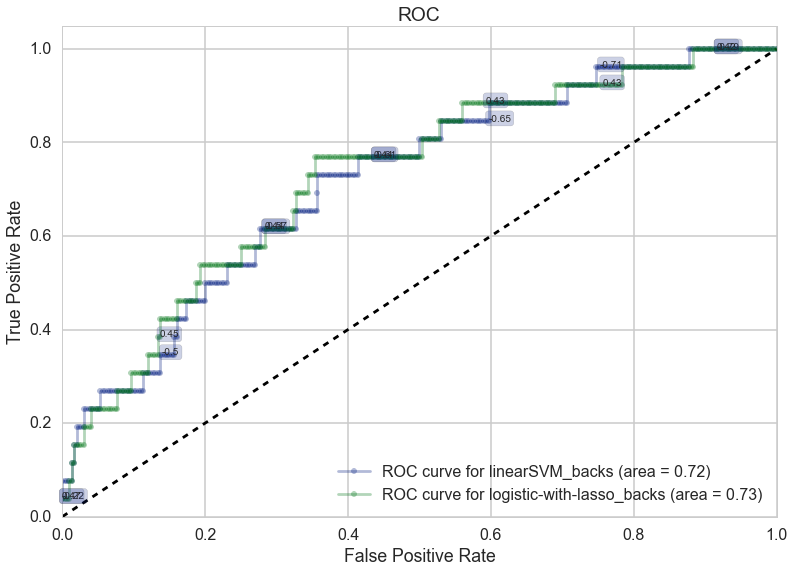

In [125]:
with sns.color_palette("dark"):
    ax=make_roc("linearSVM_backs", clfsvm_backs, ytest_backs_svm, Xtest_backs_svm, proba=False, labe=50)
    make_roc("logistic-with-lasso_backs", clflog_backs, ytest_backs_log, Xtest_backs_log, ax, proba=True, labe=50);

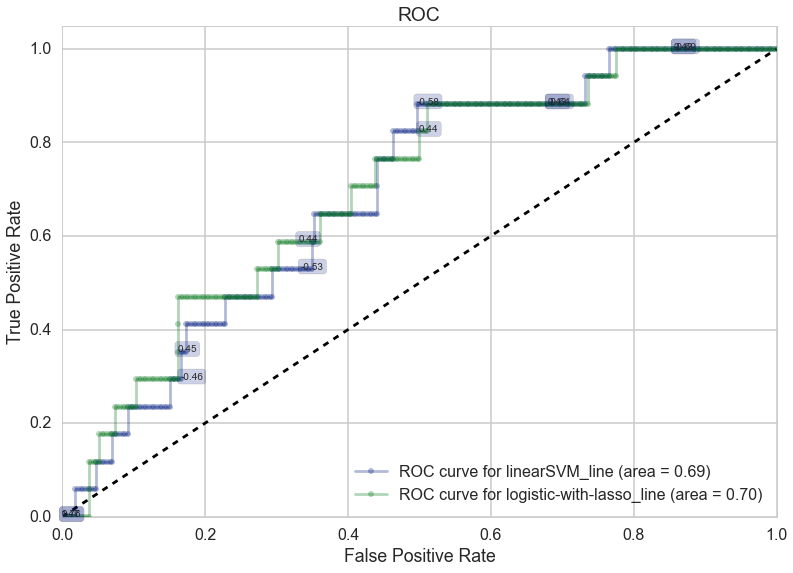

In [126]:
with sns.color_palette("dark"):
    ax=make_roc("linearSVM_line", clfsvm_line, ytest_line_svm, Xtest_line_svm, proba=False, labe=50)
    make_roc("logistic-with-lasso_line", clflog_line, ytest_line_log, Xtest_line_log, ax, proba=True, labe=50);

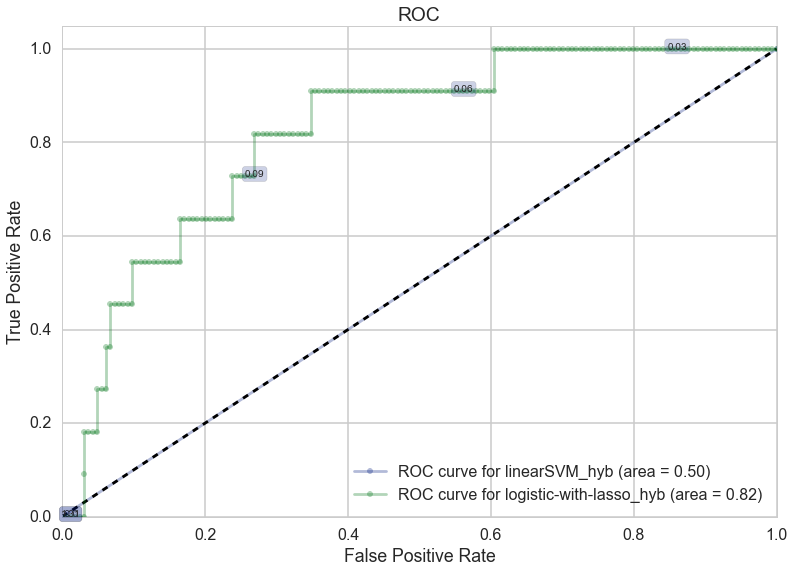

In [127]:
with sns.color_palette("dark"):
    ax=make_roc("linearSVM_hyb", clfsvm_hyb, ytest_hyb_svm, Xtest_hyb_svm, proba=False, labe=50)
    make_roc("logistic-with-lasso_hyb", clflog_hyb, ytest_hyb_log, Xtest_hyb_log, ax, proba=True, labe=50);

##Final Analysis

How do we answer our initial questions:

1. **Is the Scouting Combine predictive of future NFL success?** Probably not, and if it is, the predictive power is very modest.
2. **Which aspects of the Combine are most predictive for which players?** The forty-yard dash was universally one of the more predictive drills. Otherwise it was tough to trust any of the patterns we saw considering our sample size issues.
3. **Are NFL teams evaluating the Combine in a predictive way?** It looks that way; our models predicting first round picks return the same results as our models predicting future Pro Bowlers.

One other note: in our analysis we kept redoing our train/test splits, and these different splits resulted in wildly different results for our models. This is what leads us to conclude that our sample size is too small.